## 1. Configuração e Carga de Dados

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import geopandas as gpd
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis


In [ ]:
df = pd.read_csv('bases_analises/df_bootstrap_regioes.csv', sep=',', on_bad_lines='warn')
df.head()

,iteration,ano,cod_regiao,nome_regiao,coluna,media,mediana,p25,p75
0,0,2018,350001,São Paulo,perc_Pop_65_mais,0.080956,0.079262,0.069103,0.089276
1,0,2018,350001,São Paulo,taxa_qtd_formal_Agropecuária,0.007194,0.002423,0.000203,0.007385
2,0,2018,350001,São Paulo,taxa_qtd_formal_Indústria_de_Transformação,0.224197,0.218152,0.140644,0.298614
3,0,2018,350001,São Paulo,ipca_alimentos_bebidas,4.030782,4.030782,4.030782,4.030782
4,0,2018,350001,São Paulo,taxa_qtd_formal_Saúde,0.033600,0.031553,0.016377,0.043427


In [ ]:
display(df['coluna'].unique())

array(['perc_Pop_65_mais', 'taxa_qtd_formal_Agropecuária',
       'taxa_qtd_formal_Indústria_de_Transformação',
       'ipca_alimentos_bebidas', 'taxa_qtd_formal_Saúde',
       'ipca_transportes', 'taxa_qtd_formal_Saneamento_e_Resíduos',
       'taxa_qtd_formal_escolaridade_4',
       'taxa_qtd_formal_Organismos_Internacionais',
       'taxa_qtd_formal_escolaridade_1', 'perc_pes_rf_ate_meio_sm',
       'per_capita_massa_rendimentos', 'ipca_vestuario', 'perc_Ido_BPC',
       'taxa_qtd_formal_Artes_e_Cultura', 'ipca_artigos_residencia',
       'taxa_qtd_formal_Informação_e_Comunicação',
       'per_capita_pib_impostos_liq_sub', 'ipca_geral',
       'taxa_qtd_formal_Construção',
       'taxa_qtd_formal_Serviços_Domésticos', 'perc_PCD_BPC',
       'taxa_qtd_formal_Serviços_Financeiros', 'per_capita_pib',
       'per_capita_pib_servicos_adm_publica', 'perc_cadunicoFam_PBF',
       'taxa_qtd_formal_Eletricidade_e_Gás', 'per_capita_pib_servicos',
       'taxa_qtd_formal_Serviços_Administrativ

In [ ]:
df_regioes = pd.read_csv('df_regioes.csv')
df_regioes.head()

,dfano,cod_ibge,emprego_formal,emp_c_sal,massa_rendimentos_num,qtd_formal_Administração_Pública,qtd_formal_Agropecuária,qtd_formal_Alojamento_e_Alimentação,qtd_formal_Artes_e_Cultura,qtd_formal_Atividades_Imobiliárias,...,perc_pes_insc_cadun,perc_Pes_PBF,perc_PCD_BPC,perc_Ido_BPC,perc_Pop_65_mais,perc_65_menos_Idoso_BPC,perc_cadunicoFam_PBF,perc_cadunicoF_CAD_EP,CD_MUN,cod_regiao
0,2018,3500105,10445,9793,21389288.64,996,692,275,20,31,...,0.146811,0.027839,0.011543,0.006029,0.155839,0.149810,0.057258,0.019410,3500105,350019
1,2018,3500204,854,828,1628663.10,309,318,2,9,0,...,0.505367,0.147568,0.005850,0.005971,0.151146,0.145175,0.093331,0.080367,3500204,350025
2,2018,3500303,6984,6791,16726576.00,855,1343,133,27,9,...,0.294709,0.133088,0.009530,0.005238,0.099051,0.093813,0.130297,0.080935,3500303,350044
3,2018,3500402,983,957,2018178.53,281,206,29,1,0,...,0.240734,0.073180,0.006423,0.009854,0.158523,0.148668,0.082357,0.056873,3500402,350044
4,2018,3500501,4605,4476,9361612.67,861,55,1201,109,2,...,0.128823,0.048411,0.008681,0.007198,0.125231,0.118034,0.122272,0.079073,3500501,350048


In [ ]:
# Lista completa que você forneceu
todas_colunas = df_regioes.columns.tolist()


identificadores = ['cod_ibge', 'dfano', 'cod_regiao']

# Lógica: Tem que ter "taxa_qtd_formal" E NÃO pode ter "escolaridade"
cols_setores = [
    c for c in todas_colunas
    if 'taxa_qtd_formal' in c
    and 'escolaridade' not in c
]

print(f"Total de colunas originais: {len(todas_colunas)}")
print(f"Setores Econômicos Selecionados: {len(cols_setores)}")
print(f"Exemplos de Setores: {cols_setores[:3]}...")

# Juntamos IDs + Setores
cols_finais = identificadores + cols_setores

# Sobrescrevemos df_regioes ou criamos um novo df_base_cluster
df_base_cluster = df_regioes[cols_finais].copy()

# Garantir que não há NaNs nas taxas (preencher com 0 é seguro para taxas de emprego)
df_base_cluster[cols_setores] = df_base_cluster[cols_setores].fillna(0)

print(f"\n✅ DataFrame Limpo Criado: {df_base_cluster.shape}")
print("   (Contém apenas IDs e Setores Econômicos puros)")

Total de colunas originais: 111
Setores Econômicos Selecionados: 21
Exemplos de Setores: ['taxa_qtd_formal_Administração_Pública', 'taxa_qtd_formal_Agropecuária', 'taxa_qtd_formal_Alojamento_e_Alimentação']...

✅ DataFrame Limpo Criado: (1935, 24)
   (Contém apenas IDs e Setores Econômicos puros)


In [ ]:

gdf_municipios = gpd.read_file('SP_Municipios_2024.shp')
gdf_municipios['CD_MUN'] = gdf_municipios['CD_MUN'].astype(str)
mapa_nomes = gdf_municipios.set_index('CD_MUN')['NM_MUN'].to_dict()
mapa_nomes

{'3513009': 'Cotia',
 '3532827': 'Nova Campina',
 '3502507': 'Aparecida',
 '3543303': 'Ribeirão Pires',
 '3542008': 'Quintana',
 '3545100': 'Salmourão',
 '3532801': 'Nova Aliança',
 '3535903': 'Paranapuã',
 '3522802': 'Itaporanga',
 '3525904': 'Jundiaí',
 '3534609': 'Osvaldo Cruz',
 '3516101': 'Florínea',
 '3508207': 'Buritizal',
 '3506904': 'Bofete',
 '3532868': 'Nova Castilho',
 '3539400': 'Piratininga',
 '3524600': 'Jacupiranga',
 '3538105': 'Pindorama',
 '3528700': 'Marabá Paulista',
 '3511508': 'Cerquilho',
 '3532843': 'Nova Canaã Paulista',
 '3553104': 'Taiaçu',
 '3500808': 'Alfredo Marcondes',
 '3541604': 'Promissão',
 '3510203': 'Capão Bonito',
 '3505609': 'Barrinha',
 '3540309': 'Pontes Gestal',
 '3541653': 'Quadra',
 '3545159': 'Saltinho',
 '3527405': 'Lucélia',
 '3542909': 'Ribeirão Bonito',
 '3517406': 'Guaíra',
 '3526100': 'Juquiá',
 '3547700': 'Santo Anastácio',
 '3546405': 'Santa Cruz do Rio Pardo',
 '3549508': 'São José da Bela Vista',
 '3550308': 'São Paulo',
 '3503000

#Análise Prévia

In [ ]:
# Filtrar o DataFrame 'df' para incluir apenas as colunas relacionadas a 'taxa_qtd_formal'
df_bootstrap = df[df['coluna'].str.startswith('taxa_qtd_formal')].copy()

print("df_bootstrap criado com sucesso, contendo apenas dados de 'taxa_qtd_formal'.")
display(df_bootstrap.head())

df_bootstrap criado com sucesso, contendo apenas dados de 'taxa_qtd_formal'.


,iteration,ano,cod_regiao,nome_regiao,coluna,media,mediana,p25,p75
1,0,2018,350001,São Paulo,taxa_qtd_formal_Agropecuária,0.007194,0.002423,0.000203,0.007385
2,0,2018,350001,São Paulo,taxa_qtd_formal_Indústria_de_Transformação,0.224197,0.218152,0.140644,0.298614
4,0,2018,350001,São Paulo,taxa_qtd_formal_Saúde,0.033600,0.031553,0.016377,0.043427
6,0,2018,350001,São Paulo,taxa_qtd_formal_Saneamento_e_Resíduos,0.008502,0.007525,0.004893,0.010918
7,0,2018,350001,São Paulo,taxa_qtd_formal_escolaridade_4,0.191161,0.180035,0.155371,0.224814


Outlier Detection Report:
                                                         min        1%  \
taxa_qtd_formal_Administração_Pública               0.000000  0.049935   
taxa_qtd_formal_Agropecuária                        0.000000  0.000029   
taxa_qtd_formal_Alojamento_e_Alimentação            0.000000  0.000000   
taxa_qtd_formal_Artes_e_Cultura                     0.000000  0.000000   
taxa_qtd_formal_Atividades_Imobiliárias             0.000000  0.000000   
taxa_qtd_formal_Atividades_Profissionais_e_Técn...  0.000000  0.000000   
taxa_qtd_formal_Comércio                            0.003752  0.026204   
taxa_qtd_formal_Construção                          0.000000  0.000000   
taxa_qtd_formal_Educação                            0.000000  0.000000   
taxa_qtd_formal_Eletricidade_e_Gás                  0.000000  0.000000   
taxa_qtd_formal_Indústria_de_Transformação          0.000000  0.000000   
taxa_qtd_formal_Indústrias_Extrativas               0.000000  0.000000   
taxa_qtd_for

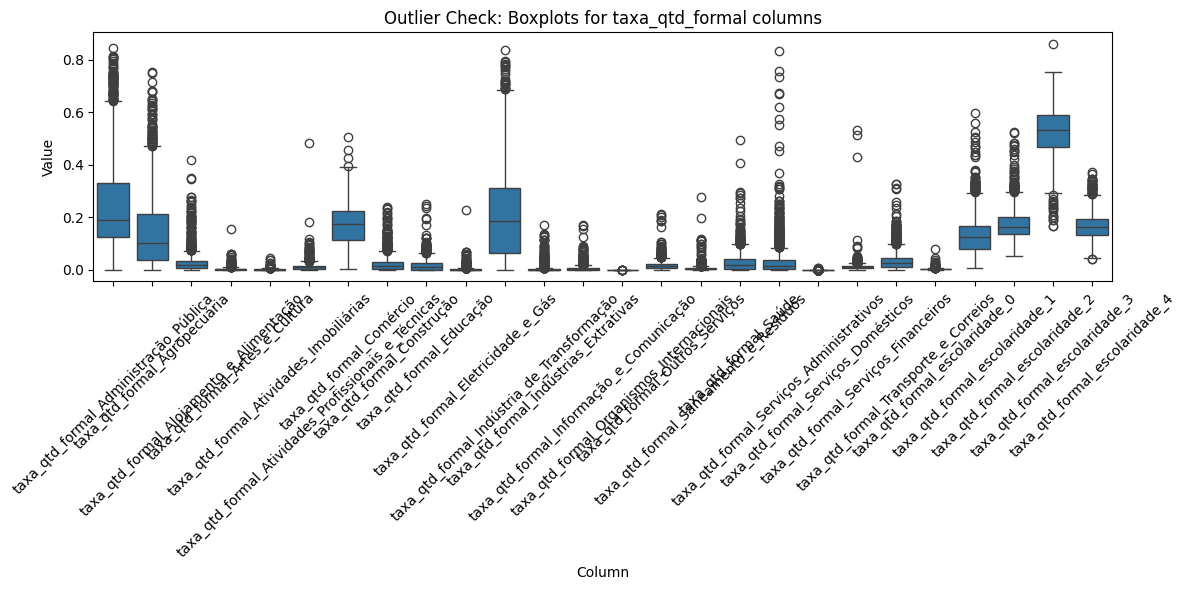

In [ ]:
df = df_regioes
# Selecionar Colunas
cols_to_check = [c for c in df.columns if c.startswith('taxa_qtd_formal')]

# Calcular percentis
stats = df[cols_to_check].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T

# Calcular Curtose e Assimetria
stats['skewness'] = df[cols_to_check].skew()
stats['kurtosis'] = df[cols_to_check].kurt()

# Conferir os Gaps
stats['upper_gap'] = stats['max'] - stats['99%']
stats['lower_gap'] = stats['1%'] - stats['min']

# Mostrar colunas
print("Outlier Detection Report:")
print(stats[['min', '1%', '50%', '99%', 'max', 'skewness', 'kurtosis','upper_gap','lower_gap']])

# Plot Boxplots for these columns
plt.figure(figsize=(12, 6))
# Melt the dataframe to a long format for easier plotting of multiple columns
df_melted = df.melt(value_vars=cols_to_check, var_name='Column', value_name='Value')

sns.boxplot(x='Column', y='Value', data=df_melted)
plt.title('Outlier Check: Boxplots for taxa_qtd_formal columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

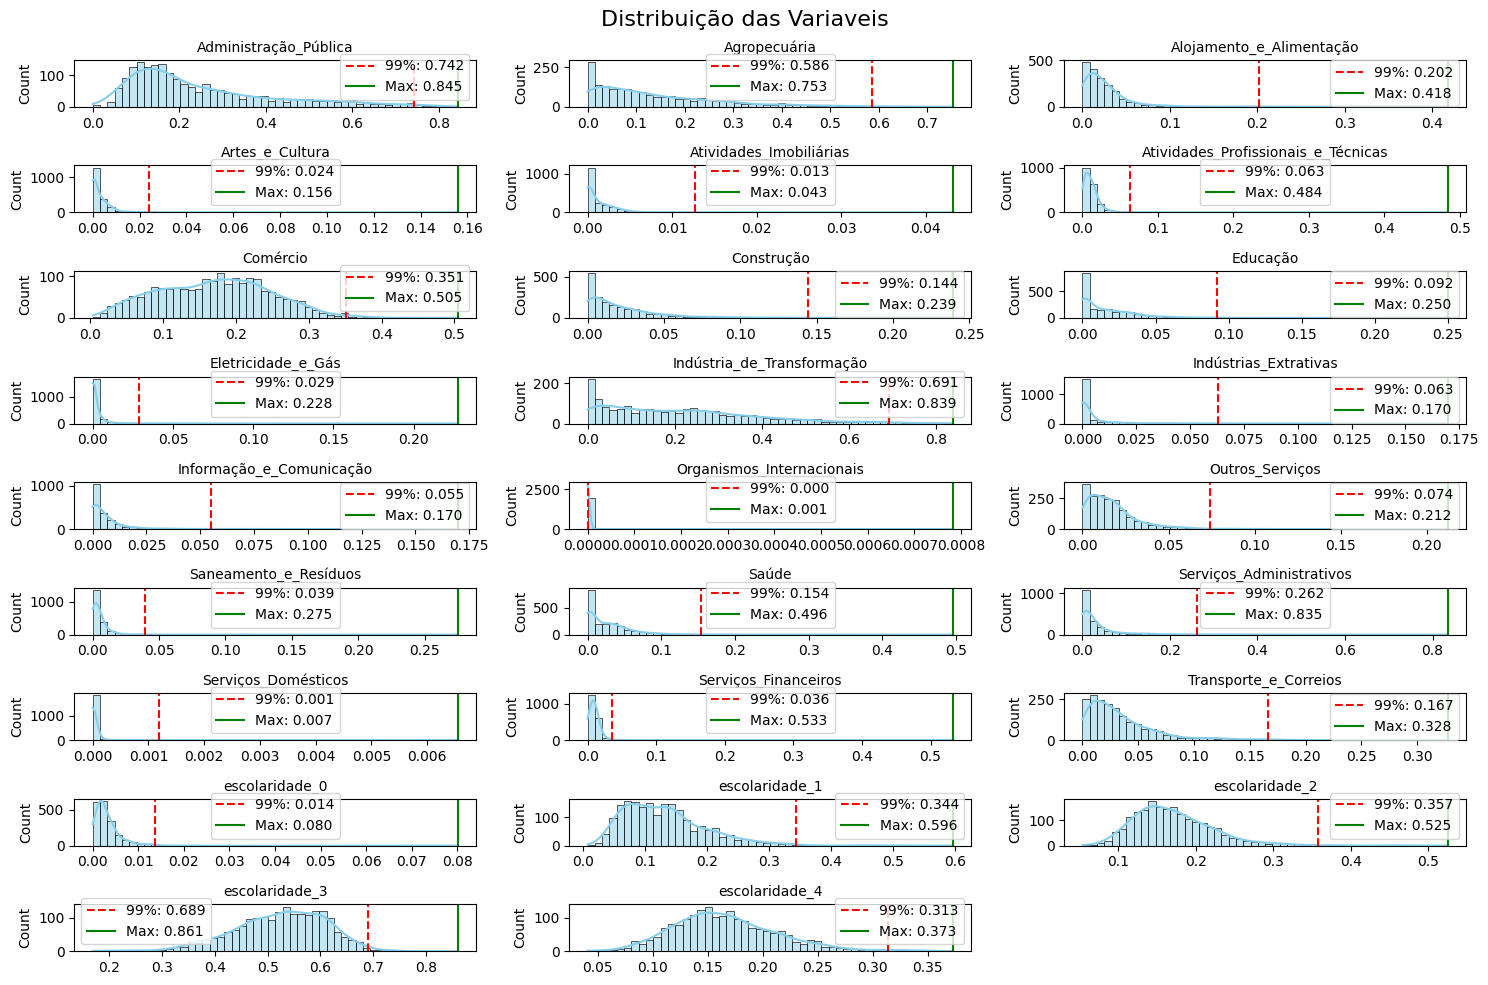

In [ ]:
#Plot
plt.figure(figsize=(15, 10))

for i, col in enumerate(cols_to_check):
    plt.subplot(9, 3, i + 1)

    # Plot histogram with a density curve (KDE)
    sns.histplot(df[col], kde=True, bins=50, color='skyblue', edgecolor='black')

    # Percentil 99
    p99 = df[col].quantile(0.99)

    #Maximo
    d_max = df[col].max()

    plt.axvline(p99, color='red', linestyle='--', label=f'99%: {p99:.3f}')
    plt.axvline(d_max, color='green', linestyle='-', label=f'Max: {d_max:.3f}')

    plt.title(col.replace('taxa_qtd_formal_', ''), fontsize=10)
    plt.legend()
    plt.xlabel('')

plt.suptitle('Distribuição das Variaveis', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#Decidimos por cortar todo setor que a mediana fosse igual a 0

termos_proibidos = [
    'Serviços_Domésticos',#Mediana 0, e comumente removido em analise economica
    'Indústrias_Extrativas',#Mediana 0
    'Organismos_Internacionais',#Mediana 0, Curtose Assustadora
    'Eletricidade_e_Gás', #Mediana 0, Curtose Alta
    'escolaridade'  # Remove todas as faixas de escolaridade de uma vez
]

# Verificar tamanho antes
tamanho_antes = len(df_bootstrap)
setores_antes = df_bootstrap['coluna'].nunique()
print(f"Linhas Antes: {tamanho_antes}")
print(f"Variáveis Únicas Antes: {setores_antes}")

# A lógica é: Manter apenas as linhas onde a coluna 'coluna' NÃO contém nenhum dos termos proibidos
padrao_regex = '|'.join(termos_proibidos)

# O til (~) inverte a lógica: pegamos o que NÃO dá match no padrão
df_bootstrap_limpo = df_bootstrap[
    ~df_bootstrap['coluna'].str.contains(padrao_regex, case=False, regex=True)
].copy()

# Atualizar o dataframe original (se quiser substituir)
df_bootstrap = df_bootstrap_limpo

# VERIFICAÇÃO
tamanho_depois = len(df_bootstrap)
setores_depois = df_bootstrap['coluna'].nunique()
removidos = setores_antes - setores_depois

print(f"\nLinhas Depois: {tamanho_depois}")
print(f"Variáveis Únicas Depois: {setores_depois}")
print(f" Variáveis Removidas: {removidos}")

# Listar o que sobrou para você conferir
print("\nAS VARIÁVEIS SOBREVIVENTES:")
print(sorted(df_bootstrap['coluna'].unique()))

Linhas Antes: 4134000
Variáveis Únicas Antes: 26

Linhas Depois: 2703000
Variáveis Únicas Depois: 17
 Variáveis Removidas: 9

AS VARIÁVEIS SOBREVIVENTES:
['taxa_qtd_formal_Administração_Pública', 'taxa_qtd_formal_Agropecuária', 'taxa_qtd_formal_Alojamento_e_Alimentação', 'taxa_qtd_formal_Artes_e_Cultura', 'taxa_qtd_formal_Atividades_Imobiliárias', 'taxa_qtd_formal_Atividades_Profissionais_e_Técnicas', 'taxa_qtd_formal_Comércio', 'taxa_qtd_formal_Construção', 'taxa_qtd_formal_Educação', 'taxa_qtd_formal_Indústria_de_Transformação', 'taxa_qtd_formal_Informação_e_Comunicação', 'taxa_qtd_formal_Outros_Serviços', 'taxa_qtd_formal_Saneamento_e_Resíduos', 'taxa_qtd_formal_Saúde', 'taxa_qtd_formal_Serviços_Administrativos', 'taxa_qtd_formal_Serviços_Financeiros', 'taxa_qtd_formal_Transporte_e_Correios']


In [ ]:
termos_proibidos = [
    'Indústrias_Extrativas',
    'Serviços_Domésticos',
    'Organismos_Internacionais',
    'Eletricidade_e_Gás',
    'escolaridade'
]

# Olhamos para TODAS as colunas do df_regioes atual
colunas_para_cortar = []
for col in df_regioes.columns:
    for termo in termos_proibidos:
        if termo in col:
            colunas_para_cortar.append(col)
            break # Se achou um termo proibido, já marca para corte

# CORTAMOS
if colunas_para_cortar:
    print(f"Encontradas {len(colunas_para_cortar)} colunas proibidas remanescentes (ex: qtd_formal).")
    print(f"Exemplos: {colunas_para_cortar[:3]}")

    df_regioes_final = df_regioes.drop(columns=colunas_para_cortar)
    df_regioes = df_regioes_final # Atualiza a variável principal
    print("Corte executado com sucesso.")
else:
    print("Nenhuma coluna proibida encontrada. O dataframe já estava limpo.")


Encontradas 18 colunas proibidas remanescentes (ex: qtd_formal).
Exemplos: ['qtd_formal_Eletricidade_e_Gás', 'qtd_formal_Indústrias_Extrativas', 'qtd_formal_Organismos_Internacionais']
Corte executado com sucesso.


#Engenharia de Features

##Cálculo Choque por Setor

 Choque Original é a medida do impacto econômico setorial (seja ele uma perda ou um ganho estrutural de relevância setorial). Ele é calculado no nível do município ($\text{m}$). A fórmula que define o impacto no setor $\text{s}$ no município $\text{m}$ é:$$\text{Choque Original}_{m, s} = \text{Taxa}_{\text{m, s}}(\text{2020}) - \text{Taxa}_{\text{m, s}}(\text{2019})$$

 $\text{Choque Original}_{m, s}$: Representa a mudança na relevância estrutural do setor $\text{s}$ no emprego formal do município $\text{m}$  devido ao choque.

 $\text{Taxa}_{\text{m, s}}(\text{t})$: É a taxa (ou proporção) de emprego formal do setor $\text{s}$ no município $\text{m}$ no ano $\text{t}$.

In [ ]:
COLUNA_TEMPO = 'dfano'
ANO_BASE = 2019
ANO_CHOQUE = 2020
COLUNA_REGIAO = 'cod_regiao'


# Coluna vazia que tinha passado
COLUNA_EXCLUIDA = 'perc_rf_ate_meio_sm'

COLUNAS_TAXAS = [col for col in df_regioes.columns if col.startswith('taxa_qtd_formal_')]
COLUNAS_TAXAS = [col for col in COLUNAS_TAXAS if col != COLUNA_EXCLUIDA]

# ===========================
# CÁLCULO DO CHOQUE ORIGINAL

# 1. Copiar e ordenar o DF original
df_choque_original = df_regioes.sort_values(by=['cod_ibge', COLUNA_TEMPO]).copy()

# 2. Calcular a diferença T2 - T1 para cada coluna, agrupando por município
df_choque_original[COLUNAS_TAXAS] = df_choque_original.groupby('cod_ibge')[COLUNAS_TAXAS].diff()

# 3. Filtrar apenas o ano de choque (agora contém a diferença T2-T1)
df_choque_municipio = df_choque_original[df_choque_original[COLUNA_TEMPO] == ANO_CHOQUE].rename(
    columns={col: f'Choque_Original_{col}' for col in COLUNAS_TAXAS}
)

# 4. Transformar o DataFrame de wide para long
df_choque_municipio = df_choque_municipio[['cod_ibge', COLUNA_REGIAO] + [f'Choque_Original_{col}' for col in COLUNAS_TAXAS]]

df_choque_long = pd.melt(
    df_choque_municipio,
    id_vars=['cod_ibge', COLUNA_REGIAO],
    value_vars=[f'Choque_Original_{col}' for col in COLUNAS_TAXAS],
    var_name='coluna_choque',
    value_name='Choque_Original'
)
df_choque_long['coluna'] = df_choque_long['coluna_choque'].str.replace('Choque_Original_', '')
df_choque_long.drop(columns=['coluna_choque'], inplace=True)
df_choque_long

,cod_ibge,cod_regiao,Choque_Original,coluna
0,3500105,350019,0.004511,taxa_qtd_formal_Administração_Pública
1,3500204,350025,0.005140,taxa_qtd_formal_Administração_Pública
2,3500303,350044,0.006136,taxa_qtd_formal_Administração_Pública
3,3500402,350044,-0.036122,taxa_qtd_formal_Administração_Pública
4,3500501,350048,-0.012622,taxa_qtd_formal_Administração_Pública
...,...,...,...,...
10960,3557006,350003,0.007442,taxa_qtd_formal_Transporte_e_Correios
10961,3557105,350027,0.000877,taxa_qtd_formal_Transporte_e_Correios
10962,3557154,350023,-0.004969,taxa_qtd_formal_Transporte_e_Correios
10963,3557204,350015,-0.000409,taxa_qtd_formal_Transporte_e_Correios


O Choque Amostral é calculado para cada iteração do bootstrap ($\text{i}$), subtraindo a média regional do ano base ($\text{2019}$) da média regional do ano do choque ($\text{2020}$):$$\text{Choque Amostral}_{r, s, i} = \text{Média}_{r, s, i}(\text{2020}) - \text{Média}_{r, s, i}(\text{2019})$$

O Intervalo de Confiança 95% é determinado utilizando os percentis do Choque Amostral obtido nas $\text{N}$ iterações, delimitando a variação esperada.$$\text{IC}_{\text{Inferior}} = \text{Percentil 2.5\%} \left( \text{Choque Amostral}_{r, s} \right)$$$$\text{IC}_{\text{Superior}} = \text{Percentil 97.5\%} \left( \text{Choque Amostral}_{r, s} \right)$$

In [ ]:
# ===============================================
# CÁLCULO DO CHOQUE AMOSTRAL E DOS ICs

COLUNA_TEMPO = 'ano'

df_bootstrap_full = df_bootstrap.copy()
print("\n2. Calculando o Intervalo de Confiança do Choque Regional (IC 95%)...")

# 1. Separar e Renomear T1 e T2
df_T1 = df_bootstrap_full[df_bootstrap_full[COLUNA_TEMPO] == ANO_BASE].copy().rename(columns={'media': 'media_T1'})
df_T2 = df_bootstrap_full[df_bootstrap_full[COLUNA_TEMPO] == ANO_CHOQUE].copy().rename(columns={'media': 'media_T2'})

df_T1 = df_T1[['iteration', COLUNA_REGIAO, 'coluna', 'media_T1']]
df_T2 = df_T2[['iteration', COLUNA_REGIAO, 'coluna', 'media_T2']]


# 2. Unir (merge) e calcular o Choque Amostral para cada iteração PAREADA
df_choque_bootstrap = pd.merge(
    df_T2, df_T1,
    on=['iteration', COLUNA_REGIAO, 'coluna'],
    how='inner'
)

# CÁLCULO DO CHOQUE AMOSTRAL
df_choque_bootstrap['Choque_Amostral'] = df_choque_bootstrap['media_T2'] - df_choque_bootstrap['media_T1']

# 3. Calcular o IC 95% do Choque Amostral (percentis 2.5 e 97.5)
ic_choque_regional = df_choque_bootstrap.groupby([COLUNA_REGIAO, 'coluna'])['Choque_Amostral'].agg(
    IC_Inferior=lambda x: x.quantile(0.025),
    IC_Superior=lambda x: x.quantile(0.975)
).reset_index()

print("\n Amostra do Intervalo de Confiança do Choque Regional (ic_choque_regional):")
print(ic_choque_regional.head())


2. Calculando o Intervalo de Confiança do Choque Regional (IC 95%)...

 Amostra do Intervalo de Confiança do Choque Regional (ic_choque_regional):
   cod_regiao                                    coluna  IC_Inferior  \
0      350001     taxa_qtd_formal_Administração_Pública    -0.031812   
1      350001              taxa_qtd_formal_Agropecuária    -0.023994   
2      350001  taxa_qtd_formal_Alojamento_e_Alimentação    -0.015300   
3      350001           taxa_qtd_formal_Artes_e_Cultura    -0.001748   
4      350001   taxa_qtd_formal_Atividades_Imobiliárias    -0.000493   

   IC_Superior  
0     0.036834  
1     0.023885  
2     0.003178  
3     0.000802  
4     0.000593  


A classificação é baseada na comparação direta entre o Choque medido no município ($\text{Choque Original}_{m, s}$) e os limites do Intervalo de Confiança Regional (IC 95%) calculados via bootstrap.

Regras de Classificação: O código utiliza a função numpy.select para aplicar as seguintes regras lógicas:

Outlier de Vulnerabilidade/Queda: O Choque do município é significativamente pior que a variação esperada para a região.$$\text{Choque Original}_{m, s} < \text{IC}_{\text{Inferior}}$$

Outlier de Resiliência/Crescimento: O Choque do município é significativamente melhor que a variação esperada para a região.$$\text{Choque Original}_{m, r, s} > \text{IC}_{\text{Superior}}$$Variação Típica: O Choque do município está dentro da faixa de variação normal e esperada para a região.$$\text{IC}_{\text{Inferior}} \le \text{Choque Original}_{m, r, s} \le \text{IC}_{\text{Superior}}$$

In [ ]:
# ===============================================
#  CLASSIFICAÇÃO UNIVARIADA FINAL DOS OUTLIERS
ic_choque_regional_filtrado = ic_choque_regional[ic_choque_regional['coluna'] != COLUNA_EXCLUIDA].copy()

# 1. Unir o Choque Original do Município com o IC Regional
df_analise_final = pd.merge(
    df_choque_long,
    ic_choque_regional_filtrado,
    on=[COLUNA_REGIAO, 'coluna'],
    how='left'
)

# 2. Classificação dos Outliers
df_analise_final['Classificacao_Outlier'] = np.select(
    [
        # Outlier Superior (Resiliência/Crescimento Atípico)
        df_analise_final['Choque_Original'] > df_analise_final['IC_Superior'],
        # Outlier Inferior (Vulnerabilidade/Choque Atípico)
        df_analise_final['Choque_Original'] < df_analise_final['IC_Inferior'],
        # Variação Típica
        df_analise_final['Choque_Original'].notna()
    ],
    [
        'Outlier de Resiliência/Crescimento (Acima do IC Regional)',
        'Outlier de Vulnerabilidade/Queda (Abaixo do IC Regional)',
        'Variação Típica (Dentro do IC Regional)'
    ],
    default='Não Classificado/Sem Dados'
)

# ===============================================
# RESULTADO FINAL

print("\nAmbos os Choques e o IC Regional, com a Classificação Final (df_analise_final):")
print(df_analise_final.head(10))

# Visualização de Resumo (Opcional, mas útil)
print("\nContagem de Classificações Finais:")
print(df_analise_final['Classificacao_Outlier'].value_counts())


Ambos os Choques e o IC Regional, com a Classificação Final (df_analise_final):
   cod_ibge  cod_regiao  Choque_Original  \
0   3500105      350019         0.004511   
1   3500204      350025         0.005140   
2   3500303      350044         0.006136   
3   3500402      350044        -0.036122   
4   3500501      350048        -0.012622   
5   3500550      350007         0.007156   
6   3500600      350040         0.016171   
7   3500709      350009        -0.011882   
8   3500758      350006         0.038018   
9   3500808      350018        -0.100461   

                                  coluna  IC_Inferior  IC_Superior  \
0  taxa_qtd_formal_Administração_Pública    -0.198782     0.214835   
1  taxa_qtd_formal_Administração_Pública    -0.045611     0.049916   
2  taxa_qtd_formal_Administração_Pública    -0.052533     0.049029   
3  taxa_qtd_formal_Administração_Pública    -0.052533     0.049029   
4  taxa_qtd_formal_Administração_Pública    -0.077063     0.065752   
5  taxa_qtd_fo

In [ ]:
# 1. Limpar df_analise_final (Formato Longo: linhas)
# Removemos as linhas onde a coluna 'coluna' contém a palavra 'escolaridade'
linhas_antes = len(df_analise_final)
df_analise_final = df_analise_final[~df_analise_final['coluna'].str.contains('escolaridade', case=False, na=False)].copy()
linhas_depois = len(df_analise_final)

print(f"df_analise_final: {linhas_antes - linhas_depois} linhas de escolaridade removidas.")

# 2. Limpar df_regioes (Formato Wide: colunas)
# Removemos as colunas que contém a palavra 'escolaridade'
cols_antes = df_regioes.shape[1]
cols_escolaridade = [c for c in df_regioes.columns if 'escolaridade' in c]
df_regioes = df_regioes.drop(columns=cols_escolaridade, errors='ignore')
cols_depois = df_regioes.shape[1]

print(f"df_regioes: {cols_antes - cols_depois} colunas de escolaridade removidas ({cols_escolaridade[:3]}...).")

print("\n✅ Dados limpos. Agora S1, S2 e S3 medirão apenas a estrutura produtiva.")

df_analise_final: 0 linhas de escolaridade removidas.
df_regioes: 0 colunas de escolaridade removidas ([]...).

✅ Dados limpos. Agora S1, S2 e S3 medirão apenas a estrutura produtiva.


##Cálculos dos Escores

In [ ]:
# Inicializando o dicionário de experimentos (se ainda não existir)
if 'inputs_experimentais' not in locals():
    inputs_experimentais = {}


###Cálculo do Score de Atipicidade de Choque Regional Robusto








$$\text{Score de Atipicidade}_{m, r, s} = \frac{\text{Choque Original}_{m, s} - \text{Mediana do Choque}_{r, s}}{\text{IQR do Choque}_{r, s} + \epsilon}$$

Onde:

$\text{Score de Atipicidade Contínua}_{m, r, s}$ é a magnitude contínua do desvio do Choque Original em relação ao seu valor central (Mediana) na região $\text{r}$, padronizada pela dispersão robusta ($\text{IQR}$) daquele contexto.

$\text{Choque Original}_{m, s}$: A variação na relevância do setor $\text{s}$ do município $\text{m}$.

$\text{Mediana do Choque}_{r, s}$: O valor central do Choque Original na região $\text{r}$ para o setor $\text{s}$.

$\text{IQR do Choque}_{r, s}$: A dispersão do Choque Original na região $\text{r}$ para o setor $\text{s}$.

$\epsilon$: Um pequeno valor de estabilização ($\text{1e-6}$) adicionado ao denominador para prevenir a divisão por zero.

In [ ]:

# Get the regional median, p25, p75 for the base year from the bootstrap data
df= df_bootstrap_full
regional_stats_base = df[df['ano'] == ANO_BASE].groupby(['cod_regiao', 'coluna'])[['mediana', 'p25', 'p75']].mean().reset_index()

# MMerde
df_analise_final = pd.merge(
    df_analise_final,
    regional_stats_base,
    on=['cod_regiao', 'coluna'],
    how='left'
)
df_economico_final = df_analise_final[
    df_analise_final['coluna'].str.startswith('taxa_qtd_formal_')
].copy()

# Calcula o Intervalo Interquartil (IQR)
df_analise_final['IQR_Regional'] = df_analise_final['p75'] - df_analise_final['p25']

# Calcula o Score de Atipicidade Robusto (Modified Z-Score)
# Formula: (Choque - Mediana) / IQR
EPSILON = 1e-6
df_analise_final['Score_Atipicidade_CONTINUO'] = (
    df_analise_final['Choque_Original'] - df_analise_final['mediana']
) / (df_analise_final['IQR_Regional'] + EPSILON)

# Filtrar e Criar a Base de Clustering
df_clustering_base_cont = df_analise_final[
    df_analise_final['Classificacao_Outlier'] != 'Não Classificado/Sem Dados'
].copy()

# Pivotar o DataFrame:
#    Valores = Score_Atipicidade_CONTINUO (Z-Score Robusto)
df_pivot_score = df_clustering_base_cont.pivot_table(
    index='cod_ibge',
    columns='coluna',
    values='Score_Atipicidade_CONTINUO', # USANDO O SCORE CONTÍNUO AQUI
    fill_value=0  # Preenche qualquer combinação Município/Variável não classificada com 0 (Típico)
)
inputs_experimentais['S1_Regional_Robusto'] = df_pivot_score.values
print("--- DataFrame Pivotado com Score Contínuo (Amostra) ---")
print("Score de Atipicidade: Valores Contínuos (Magnitude do Desvio)")
print(df_pivot_score.head())

--- DataFrame Pivotado com Score Contínuo (Amostra) ---
Score de Atipicidade: Valores Contínuos (Magnitude do Desvio)
coluna    taxa_qtd_formal_Administração_Pública  taxa_qtd_formal_Agropecuária  \
cod_ibge                                                                        
3500105                               -0.912264                     -0.829424   
3500204                               -1.288817                     -0.930583   
3500303                               -2.425383                     -1.815467   
3500402                               -3.307518                     -1.558199   
3500501                               -2.823376                     -2.254807   

coluna    taxa_qtd_formal_Alojamento_e_Alimentação  \
cod_ibge                                             
3500105                                  -1.061997   
3500204                                  -0.612256   
3500303                                  -1.653055   
3500402                                  -1.

In [ ]:

# Colunas De Perfil Econômico
colunas_economicas_puras = [
    col for col in df_pivot_score.columns
    if col.startswith('taxa_qtd_formal_')
    and not col.startswith('taxa_qtd_formal_escolaridade_')
    and col != 'taxa_qtd_formal_Serviços_Domésticos'
]

# Cria a nova matriz de clustering
df_pivot_economico_puro = df_pivot_score[colunas_economicas_puras].copy()

print("\n✅ Matriz 'df_pivot_economico_puro' criada com sucesso.")
print(f"Colunas restantes (Setores Econômicos Puros): {len(df_pivot_economico_puro.columns)}")
print(df_pivot_economico_puro.head())


✅ Matriz 'df_pivot_economico_puro' criada com sucesso.
Colunas restantes (Setores Econômicos Puros): 17
coluna    taxa_qtd_formal_Administração_Pública  taxa_qtd_formal_Agropecuária  \
cod_ibge                                                                        
3500105                               -0.912264                     -0.829424   
3500204                               -1.288817                     -0.930583   
3500303                               -2.425383                     -1.815467   
3500402                               -3.307518                     -1.558199   
3500501                               -2.823376                     -2.254807   

coluna    taxa_qtd_formal_Alojamento_e_Alimentação  \
cod_ibge                                             
3500105                                  -1.061997   
3500204                                  -0.612256   
3500303                                  -1.653055   
3500402                                  -1.315009   
350

###Cálculo do Escore de Atipicidade  de Choque Estadual Robusto

$$\text{Score Estadual}_{m, s} = \frac{\text{Choque}_{m, s} - \text{Mediana Estadual}_{s}}{\text{IQR Estadual}_{s} + \epsilon}$$$\text{Mediana Estadual}_{s}$: O valor central do choque no setor $s$ em todo o estado.$\text{IQR Estadual}_{s}$: A dispersão ($\text{P}_{75} - \text{P}_{25}$) do choque no setor $s$ em todo o estado.

In [ ]:
df_s2_calc = df_analise_final.copy()

# Valcular Mediana e IQR GLOBAIS (Agrupando apenas por 'coluna'/setor, ignorando região)
stats_estadual = df_s2_calc.groupby('coluna')['Choque_Original'].agg(
    mediana_est='median',
    p25_est=lambda x: x.quantile(0.25),
    p75_est=lambda x: x.quantile(0.75)
).reset_index()

# Merge de volta
df_s2_calc = pd.merge(df_s2_calc, stats_estadual, on='coluna', how='left')

# Calcular IQR Estadual
df_s2_calc['IQR_Estadual'] = df_s2_calc['p75_est'] - df_s2_calc['p25_est']

#  Calcular Score Robusto Estadual
# Fórmula: (Choque - Mediana_Estadual) / (IQR_Estadual + Epsilon)
EPSILON = 1e-6
df_s2_calc['Score_S2'] = (df_s2_calc['Choque_Original'] - df_s2_calc['mediana_est']) / (df_s2_calc['IQR_Estadual'] + EPSILON)

# Pivotar para formato de matriz (Município x Setor)
df_pivot_s2 = df_s2_calc.pivot_table(
    index='cod_ibge',
    columns='coluna',
    values='Score_S2',
    fill_value=0
)
inputs_experimentais['S2_Estadual_Robusto'] = df_pivot_s2.values


###Cálculo do Score de Trajétoria Robusto

$$\text{Score Trajetoria}_{m, s, t} = \frac{\text{Taxa}_{m, s, t} - \text{Mediana}_{s, t}}{\text{IQR}_{s, t} + \epsilon}$$

t aqui representa o ano


In [ ]:
# ==============================================================================
# CÁLCULO DO SCORE S3: TRAJETÓRIA TEMPORAL ROBUSTA
print("\n--- Calculando S3 (Trajetória Temporal Robusta) ---")

# Garantir que cod_ibge seja uma coluna acessível
df_traj_safe = df_regioes.copy()
if 'cod_ibge' not in df_traj_safe.columns and df_traj_safe.index.name == 'cod_ibge':
    df_traj_safe = df_traj_safe.reset_index()
    print("Aviso: 'cod_ibge' estava no índice e foi movido para coluna.")

# Definição das Colunas e Anos (Baseado no seu diagnóstico)
cols_taxas = [c for c in df_traj_safe.columns if 'taxa_qtd_formal' in c]
anos_analise = [2018, 2019, 2020]

print(f"Colunas de taxa encontradas: {len(cols_taxas)}")

# Filtragem e Pivotagem
df_traj_filtered = df_traj_safe[df_traj_safe['dfano'].isin(anos_analise)]

# Pivotar
df_pivot_traj = df_traj_filtered.pivot_table(
    index='cod_ibge',
    columns='dfano',
    values=cols_taxas,
    fill_value=0
)

# Achatamento das Colunas
# O pivot cria um MultiIndex (Setor, Ano). Vamos achatar para 'Setor_Ano'
df_pivot_traj.columns = [f'{col}_{ano}' for col, ano in df_pivot_traj.columns]

# Cálculo Manual das Estatísticas Robustas Globais (S3 usa Benchmark Global)
mediana_traj = df_pivot_traj.median()
p25_traj = df_pivot_traj.quantile(0.25)
p75_traj = df_pivot_traj.quantile(0.75)
iqr_traj = p75_traj - p25_traj

# Aplicação da Fórmula Modified Z-Score
EPSILON = 1e-6
df_s3_robust = (df_pivot_traj - mediana_traj) / (iqr_traj + EPSILON)

# Armazenar no Dicionário
inputs_experimentais['S3_Trajetoria_Robust'] = df_s3_robust.values

print(f"S3 Criado com Sucesso. Shape: {inputs_experimentais['S3_Trajetoria_Robust'].shape}")



--- Calculando S3 (Trajetória Temporal Robusta) ---
Colunas de taxa encontradas: 17
S3 Criado com Sucesso. Shape: (645, 51)


##PCA dos Scores

In [ ]:
# Lista auxiliar para iterar sobre os inputs originais
keys_originais = list(inputs_experimentais.keys())

for key in keys_originais:
    if 'PCA' in key:
        continue
    X_original = inputs_experimentais[key]

    # 1. Configurar PCA
    # Manter 90% da variância explicada
    pca = PCA(n_components=0.90, random_state=42)

    # 2. Fit e Transform
    X_pca = pca.fit_transform(X_original)

    # 3. Criar nome do novo Input (Ex: S1_Regional_Robust -> S1_Regional_Robust_PCA)
    new_key = key + "_PCA"
    inputs_experimentais[new_key] = X_pca

    # 4. Relatório Rápido
    n_components = X_pca.shape[1]
    original_dims = X_original.shape[1]
    explained_var = np.sum(pca.explained_variance_ratio_)

    print(f"\n Origem: {key} ({original_dims} colunas)")
    print(f" Componentes: {new_key} ({n_components} componentes)")
    print(f" Variância Retida: {explained_var:.1%}")



print(f"\nTotal de Inputs prontos para Clusterização: {len(inputs_experimentais)}")
print(list(inputs_experimentais.keys()))


 Origem: S1_Regional_Robusto (17 colunas)
 Componentes: S1_Regional_Robusto_PCA (10 componentes)
 Variância Retida: 90.2%

 Origem: S2_Estadual_Robusto (17 colunas)
 Componentes: S2_Estadual_Robusto_PCA (9 componentes)
 Variância Retida: 91.1%

 Origem: S3_Trajetoria_Robust (51 colunas)
 Componentes: S3_Trajetoria_Robust_PCA (14 componentes)
 Variância Retida: 91.2%

Total de Inputs prontos para Clusterização: 6
['S1_Regional_Robusto', 'S2_Estadual_Robusto', 'S3_Trajetoria_Robust', 'S1_Regional_Robusto_PCA', 'S2_Estadual_Robusto_PCA', 'S3_Trajetoria_Robust_PCA']


##Winsorização (Tukey 1962)

A Winsotrização é uma técnica usada para diminuir assimetria. Se determina um percentil, e todo valor mais extremo que o valor apresentado naquele percentil se torna ele.

In [ ]:
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
cortes_teste = [0.00, 0.01, 0.025, 0.05, 0.10]
chaves_brutas = ['S1_Regional_Robusto', 'S2_Estadual_Robusto', 'S3_Trajetoria_Robust']
resultados_gerais = []

for nome_input in chaves_brutas:
    if nome_input not in inputs_experimentais: continue

    # Converter para array numpy
    X_raw = np.array(inputs_experimentais[nome_input], dtype=float)

    # Tratamento prévio: substituir infinitos por NaN
    X_raw[np.isinf(X_raw)] = np.nan

    for c in cortes_teste:
        assimetrias_colunas = []

        # Iterar coluna por coluna
        for i in range(X_raw.shape[1]):
            col = X_raw[:, i].copy()

            # Remover NaNs para o cálculo dos limites
            col_valid = col[~np.isnan(col)]

            if len(col_valid) == 0 or np.std(col_valid) == 0:
                # Se a coluna é toda vazia ou toda igual (constante), a assimetria é 0
                assimetrias_colunas.append(0)
                continue

            if c > 0:
                # Calcular os percentis ignorando NaNs
                lower_limit = np.percentile(col_valid, c * 100)
                upper_limit = np.percentile(col_valid, (1 - c) * 100)

                # Winsorizar os valores
                col = np.clip(col, lower_limit, upper_limit)

            # Calcular Assimetria
            s = skew(col, nan_policy='omit')

            # Se ainda der NaN (caso muito raro matemático), vira 0
            if np.isnan(s): s = 0

            assimetrias_colunas.append(s)

        # Média Absoluta das Assimetrias
        sk_media = np.mean(np.abs(assimetrias_colunas))

        # Diagnóstico Visual
        status = " RUIM"
        if sk_media < 3.0: status = "Aceitável"
        if sk_media < 2.0: status = "BOM"

        resultados_gerais.append({
            'Input': nome_input,
            'Corte (%)': f"{c*100}%",
            'Assimetria Média': sk_media, # Mantive float para precisão no pivot
            'Status': status
        })

# Formatando a Tabela Final
df_sensibilidade = pd.DataFrame(resultados_gerais)

# Pivotar para comparação
df_pivot = df_sensibilidade.pivot(index='Corte (%)', columns='Input', values='Assimetria Média')
print(df_pivot.round(2))

print("\n--- Detalhe com Status ---")
print(df_sensibilidade[['Input', 'Corte (%)', 'Assimetria Média', 'Status']].set_index(['Input', 'Corte (%)']))

Input      S1_Regional_Robusto  S2_Estadual_Robusto  S3_Trajetoria_Robust
Corte (%)                                                                
0.0%                      4.11                 5.73                  5.26
1.0%                      1.22                 0.83                  1.89
10.0%                     0.46                 0.44                  0.62
2.5%                      0.85                 0.58                  1.34
5.0%                      0.68                 0.50                  0.98

--- Detalhe com Status ---
                                Assimetria Média Status
Input                Corte (%)                         
S1_Regional_Robusto  0.0%               4.108550   RUIM
                     1.0%               1.222314    BOM
                     2.5%               0.851482    BOM
                     5.0%               0.681731    BOM
                     10.0%              0.461082    BOM
S2_Estadual_Robusto  0.0%               5.726656   RUIM
      

Pelos valores de assimetria calculados para cada corte, podemos concluir que um corte de 1% é suficiente para tornar os dados mais amigáveis.

In [ ]:
keys_originais = [k for k in inputs_experimentais.keys() if '_PCA' not in k and '_Win' not in k]

print(f"Processando datasets: {keys_originais}\n")

for key in keys_originais:

    # Garantir que é array numpy de floats
    X_raw = np.array(inputs_experimentais[key], dtype=float)

    # WINSORIZAÇÃO
    X_win_masked = winsorize(X_raw, limits=[0.01, 0.01], axis=0)

    # Se houver dados mascarados (originais eram NaN), preenchemos
    X_win = np.ma.getdata(X_win_masked)

    # Tratamento de segurança final: Se sobrou algum NaN (muito raro), preenche com a média
    imputer = SimpleImputer(strategy='mean')
    X_win = imputer.fit_transform(X_win)

    # PCA (Refazendo sobre o dado tratado)
    pca = PCA(n_components=0.90, random_state=42)
    X_pca = pca.fit_transform(X_win)

    # Sobrescrevemos a chave _PCA para garantir que usaremos esta versão corrigida
    new_key = key + "_PCA"
    inputs_experimentais[new_key] = X_pca

    # Relatório
    dims_antes = X_raw.shape[1]
    dims_depois = X_pca.shape[1]
    var_retida = np.sum(pca.explained_variance_ratio_)

    print(f"{key}: Winsor(1%) Aplicado.")
    print(f"PCA Gerado ({new_key}): {dims_antes} cols -> {dims_depois} componentes (Var: {var_retida:.1%})")



Processando datasets: ['S1_Regional_Robusto', 'S2_Estadual_Robusto', 'S3_Trajetoria_Robust']

S1_Regional_Robusto: Winsor(1%) Aplicado.
PCA Gerado (S1_Regional_Robusto_PCA): 17 cols -> 12 componentes (Var: 90.7%)
S2_Estadual_Robusto: Winsor(1%) Aplicado.
PCA Gerado (S2_Estadual_Robusto_PCA): 17 cols -> 11 componentes (Var: 91.2%)
S3_Trajetoria_Robust: Winsor(1%) Aplicado.
PCA Gerado (S3_Trajetoria_Robust_PCA): 51 cols -> 14 componentes (Var: 91.0%)


In [ ]:
df_bootstrap

,iteration,ano,cod_regiao,nome_regiao,coluna,media,mediana,p25,p75
1,0,2018,350001,São Paulo,taxa_qtd_formal_Agropecuária,0.007194,0.002423,0.000203,0.007385
2,0,2018,350001,São Paulo,taxa_qtd_formal_Indústria_de_Transformação,0.224197,0.218152,0.140644,0.298614
4,0,2018,350001,São Paulo,taxa_qtd_formal_Saúde,0.033600,0.031553,0.016377,0.043427
6,0,2018,350001,São Paulo,taxa_qtd_formal_Saneamento_e_Resíduos,0.008502,0.007525,0.004893,0.010918
14,0,2018,350001,São Paulo,taxa_qtd_formal_Artes_e_Cultura,0.005196,0.003473,0.002290,0.005470
...,...,...,...,...,...,...,...,...,...
8585986,999,2020,350053,Cruzeiro,taxa_qtd_formal_Transporte_e_Correios,0.013358,0.013846,0.003937,0.022493
8585987,999,2020,350053,Cruzeiro,taxa_qtd_formal_Atividades_Imobiliárias,0.001273,0.000611,0.000000,0.002711
8585988,999,2020,350053,Cruzeiro,taxa_qtd_formal_Outros_Serviços,0.022304,0.013780,0.012804,0.018543
8585989,999,2020,350053,Cruzeiro,taxa_qtd_formal_Comércio,0.140094,0.179393,0.083444,0.191591


#Análises de Agrupamento

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import warnings

##Grid Search

In [ ]:
# Filtrar apenas os inputs FINAIS (Winsorizado a 1% )
inputs_batalha = {k: v for k, v in inputs_experimentais.items()}

resultados_avancados = []

for nome_input, X in inputs_batalha.items():

    print(f"Analisando: {nome_input}...")

    # Testar K de 3 a 7
    for k in range(3, 8):
        # K-Means
        model_km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
        labels_km = model_km.labels_

        #Hierárquico (Ward)
        model_hc = AgglomerativeClustering(n_clusters=k).fit(X)
        labels_hc = model_hc.labels_

        # GMM
        model_gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
        labels_gmm = model_gmm.predict(X)

        # Função auxiliar para calcular métricas
        def calc_metrics(labels, algo_name):
            # Tamanhos
            unique, counts = np.unique(labels, return_counts=True)
            if len(unique) < 2: return # Erro

            min_size = np.min(counts)
            max_size = np.max(counts)
            ratio = max_size / min_size

            # Scores
            sil = silhouette_score(X, labels)
            ch = calinski_harabasz_score(X, labels)
            db = davies_bouldin_score(X, labels)

            resultados_avancados.append({
                'Input': nome_input,
                'Algoritmo': algo_name,
                'K': k,
                'Silhouette (Max)': sil,     # Queremos Alto
                'Calinski (Max)': ch,        # Queremos Alto (Densidade)
                'Davies-Bouldin (Min)': db,  # Queremos Baixo (Separação)
                'Menor Grupo': min_size,     # Queremos Alto
                'Desbalanço (Ratio)': ratio  # Queremos Baixo
            })

        calc_metrics(labels_km, 'K-Means')
        calc_metrics(labels_hc, 'Hierarquico')
        calc_metrics(labels_gmm, 'GMM')

# --- TABELA FINAL ---
df_adv = pd.DataFrame(resultados_avancados)

print(df_adv.sort_values(by='Silhouette (Max)', ascending=False).head(15).to_string(index=False))

Analisando: S1_Regional_Robusto...
Analisando: S2_Estadual_Robusto...
Analisando: S3_Trajetoria_Robust...
Analisando: S1_Regional_Robusto_PCA...
Analisando: S2_Estadual_Robusto_PCA...
Analisando: S3_Trajetoria_Robust_PCA...
                  Input   Algoritmo  K  Silhouette (Max)  Calinski (Max)  Davies-Bouldin (Min)  Menor Grupo  Desbalanço (Ratio)
    S2_Estadual_Robusto Hierarquico  3          0.856403      165.363321              0.166865            1          641.000000
    S2_Estadual_Robusto Hierarquico  4          0.853522      163.685921              0.229655            1          639.000000
    S2_Estadual_Robusto         GMM  3          0.849950      127.423224              0.229953            1          642.000000
    S2_Estadual_Robusto     K-Means  4          0.840258      166.045225              0.286273            1          638.000000
    S2_Estadual_Robusto         GMM  4          0.840258      166.045225              0.286273            1          638.000000
    S2_E

In [ ]:
#Vamos Filtrar os modelos com grupos pequenos demais
df_uteis = df_adv[df_adv['Menor Grupo'] >= 10].copy()

if len(df_uteis) == 0:
    print("ALERTA: Todos os modelos geraram grupos menores que 10 cidades!")
    df_show = df_adv
else:
    print(f"\nFiltramos {len(df_adv) - len(df_uteis)} modelos com clusters muito pequenos (<10).")
    df_show = df_uteis

print(df_show.sort_values(by='Silhouette (Max)', ascending=False).head(15).to_string(index=False))


Filtramos 52 modelos com clusters muito pequenos (<10).
                   Input   Algoritmo  K  Silhouette (Max)  Calinski (Max)  Davies-Bouldin (Min)  Menor Grupo  Desbalanço (Ratio)
 S2_Estadual_Robusto_PCA     K-Means  3          0.602414      161.506991              0.695356           14           43.857143
 S2_Estadual_Robusto_PCA     K-Means  4          0.378059      133.739549              1.371529           14           40.714286
 S1_Regional_Robusto_PCA     K-Means  3          0.275847      205.772192              1.436850           34           11.911765
 S1_Regional_Robusto_PCA Hierarquico  4          0.272757      148.733276              1.242394           12           33.583333
 S1_Regional_Robusto_PCA         GMM  3          0.272283      186.698502              1.338080           15           26.466667
 S1_Regional_Robusto_PCA Hierarquico  3          0.272176      196.030932              1.406389           25           16.120000
 S2_Estadual_Robusto_PCA     K-Means  5 


ANALISANDO: S2_Estadual_Robusto_PCA | K-Means | K=3

>>> CLUSTER 0 (17 municípios - 2.6%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Comércio: +0.01168
      + taxa_qtd_formal_Indústria_de_Transformação: +0.00594
      + taxa_qtd_formal_Atividades_Imobiliárias: +0.00245
      + taxa_qtd_formal_Serviços_Financeiros: +0.00000
      + taxa_qtd_formal_Educação: +0.00000
   PONTOS DE ATENÇÃO (Onde caiu):
      - taxa_qtd_formal_Saneamento_e_Resíduos: -0.00025
      - taxa_qtd_formal_Construção: -0.00047
      - taxa_qtd_formal_Transporte_e_Correios: -0.00115
      - taxa_qtd_formal_Alojamento_e_Alimentação: -0.00379
      - taxa_qtd_formal_Administração_Pública: -0.00399

>>> CLUSTER 1 (614 municípios - 95.2%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Indústria_de_Transformação: +0.00187
      + taxa_qtd_formal_Serviços_Administrativos: +0.00023
      + taxa_qtd_formal_Atividades_Profissionais_e_Técnicas: +0.00014
      + taxa_qtd_fo

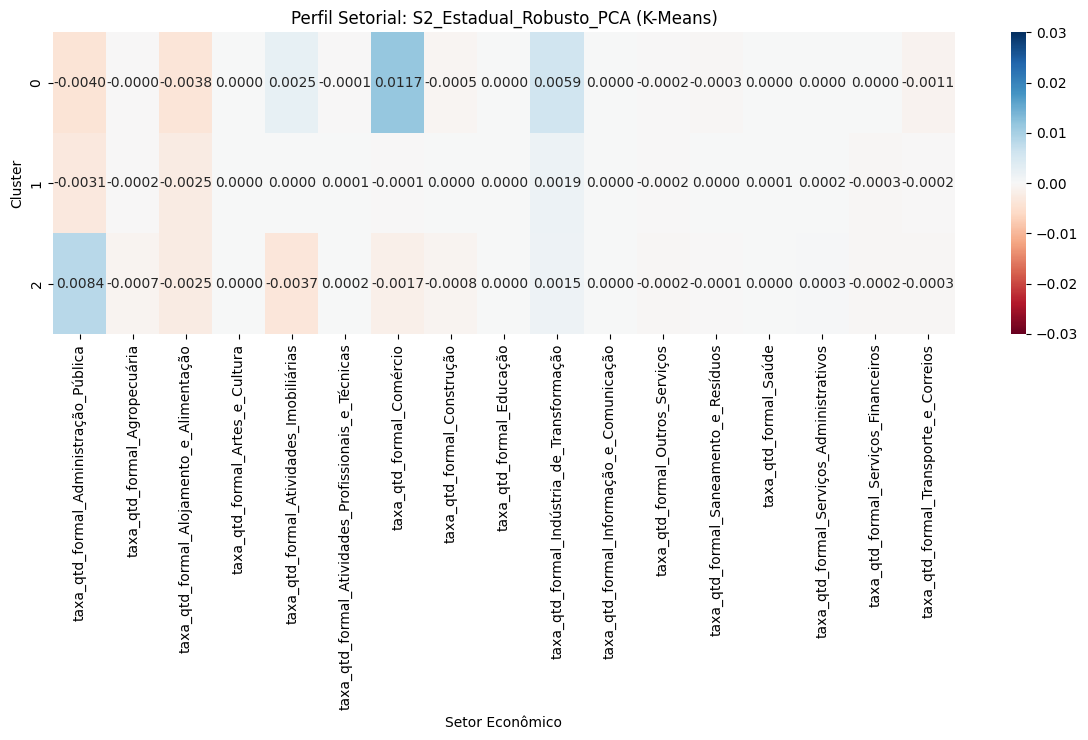


ANALISANDO: S3_Trajetoria_Robust_PCA | K-Means | K=3

>>> CLUSTER 0 (61 municípios - 9.5%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Serviços_Administrativos: +0.00848
      + taxa_qtd_formal_Saúde: +0.00212
      + taxa_qtd_formal_Indústria_de_Transformação: +0.00092
      + taxa_qtd_formal_Construção: +0.00092
      + taxa_qtd_formal_Atividades_Profissionais_e_Técnicas: +0.00057
   PONTOS DE ATENÇÃO (Onde caiu):
      - taxa_qtd_formal_Educação: -0.00127
      - taxa_qtd_formal_Outros_Serviços: -0.00132
      - taxa_qtd_formal_Administração_Pública: -0.00140
      - taxa_qtd_formal_Comércio: -0.00263
      - taxa_qtd_formal_Alojamento_e_Alimentação: -0.00599

>>> CLUSTER 1 (263 municípios - 40.8%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Indústria_de_Transformação: +0.00456
      + taxa_qtd_formal_Saúde: +0.00114
      + taxa_qtd_formal_Construção: +0.00083
      + taxa_qtd_formal_Serviços_Administrativos: +0.00045
      + t

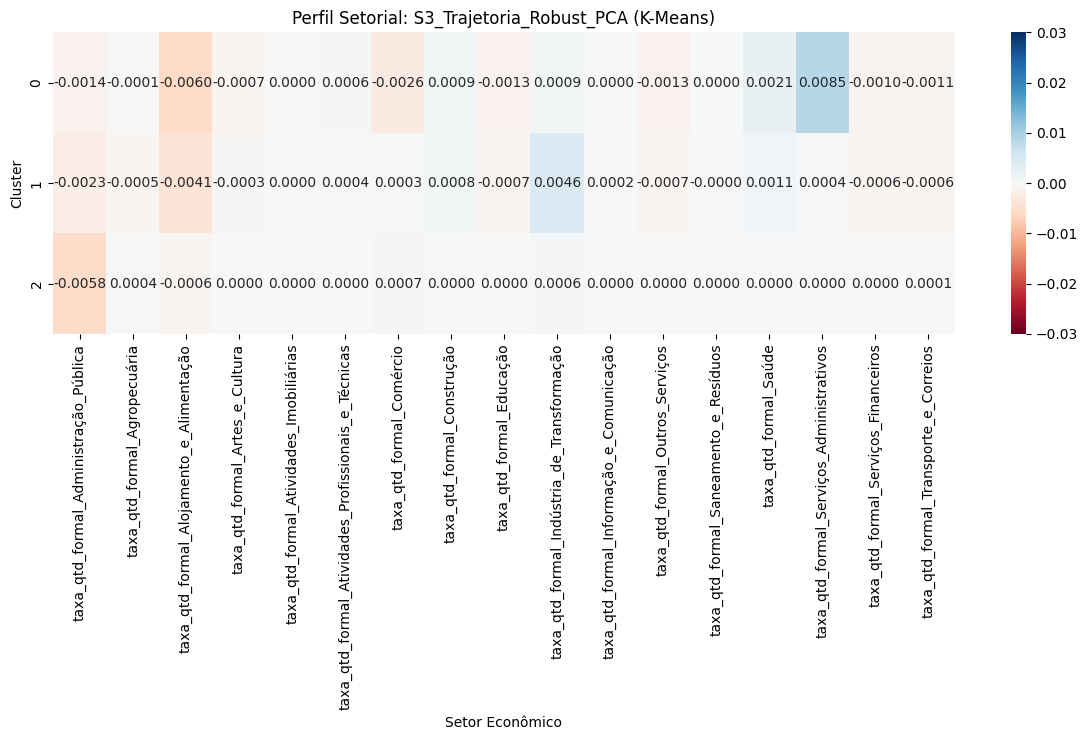


ANALISANDO: S3_Trajetoria_Robust_PCA | K-Means | K=4

>>> CLUSTER 0 (242 municípios - 37.5%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Indústria_de_Transformação: +0.00598
      + taxa_qtd_formal_Construção: +0.00076
      + taxa_qtd_formal_Saúde: +0.00071
      + taxa_qtd_formal_Serviços_Administrativos: +0.00066
      + taxa_qtd_formal_Atividades_Profissionais_e_Técnicas: +0.00020
   PONTOS DE ATENÇÃO (Onde caiu):
      - taxa_qtd_formal_Serviços_Financeiros: -0.00060
      - taxa_qtd_formal_Outros_Serviços: -0.00071
      - taxa_qtd_formal_Agropecuária: -0.00092
      - taxa_qtd_formal_Alojamento_e_Alimentação: -0.00324
      - taxa_qtd_formal_Administração_Pública: -0.00355

>>> CLUSTER 1 (277 municípios - 42.9%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Comércio: +0.00098
      + taxa_qtd_formal_Agropecuária: +0.00066
      + taxa_qtd_formal_Indústria_de_Transformação: +0.00021
      + taxa_qtd_formal_Transporte_e_Correios

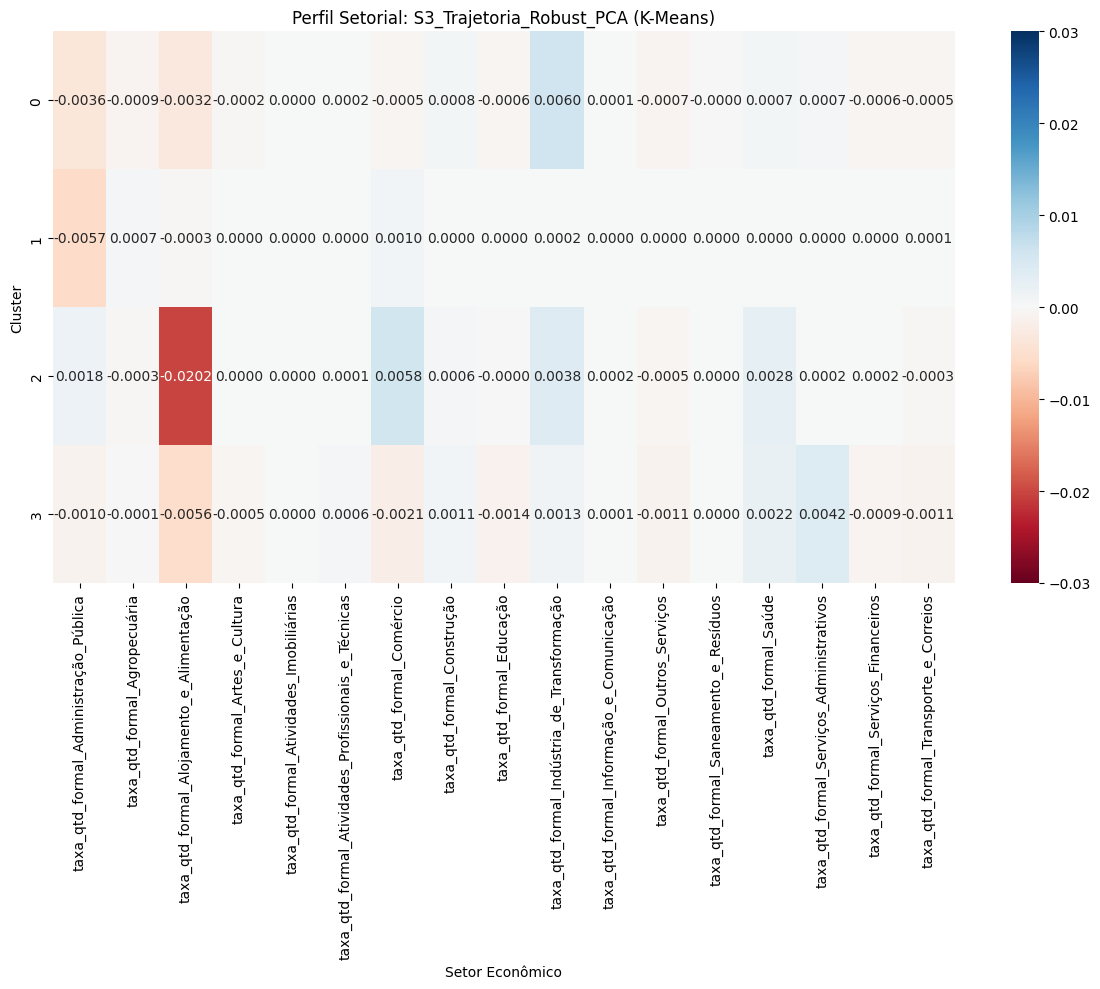


ANALISANDO: S3_Trajetoria_Robust_PCA | K-Means | K=6

>>> CLUSTER 0 (226 municípios - 35.0%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Comércio: +0.00203
      + taxa_qtd_formal_Agropecuária: +0.00080
      + taxa_qtd_formal_Transporte_e_Correios: +0.00007
      + taxa_qtd_formal_Indústria_de_Transformação: +0.00004
      + taxa_qtd_formal_Atividades_Profissionais_e_Técnicas: +0.00004
   PONTOS DE ATENÇÃO (Onde caiu):
      - taxa_qtd_formal_Construção: +0.00000
      - taxa_qtd_formal_Serviços_Financeiros: +0.00000
      - taxa_qtd_formal_Informação_e_Comunicação: +0.00000
      - taxa_qtd_formal_Alojamento_e_Alimentação: -0.00009
      - taxa_qtd_formal_Administração_Pública: -0.00506

>>> CLUSTER 1 (45 municípios - 7.0%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Serviços_Administrativos: +0.00853
      + taxa_qtd_formal_Saúde: +0.00169
      + taxa_qtd_formal_Construção: +0.00112
      + taxa_qtd_formal_Atividades_Profission

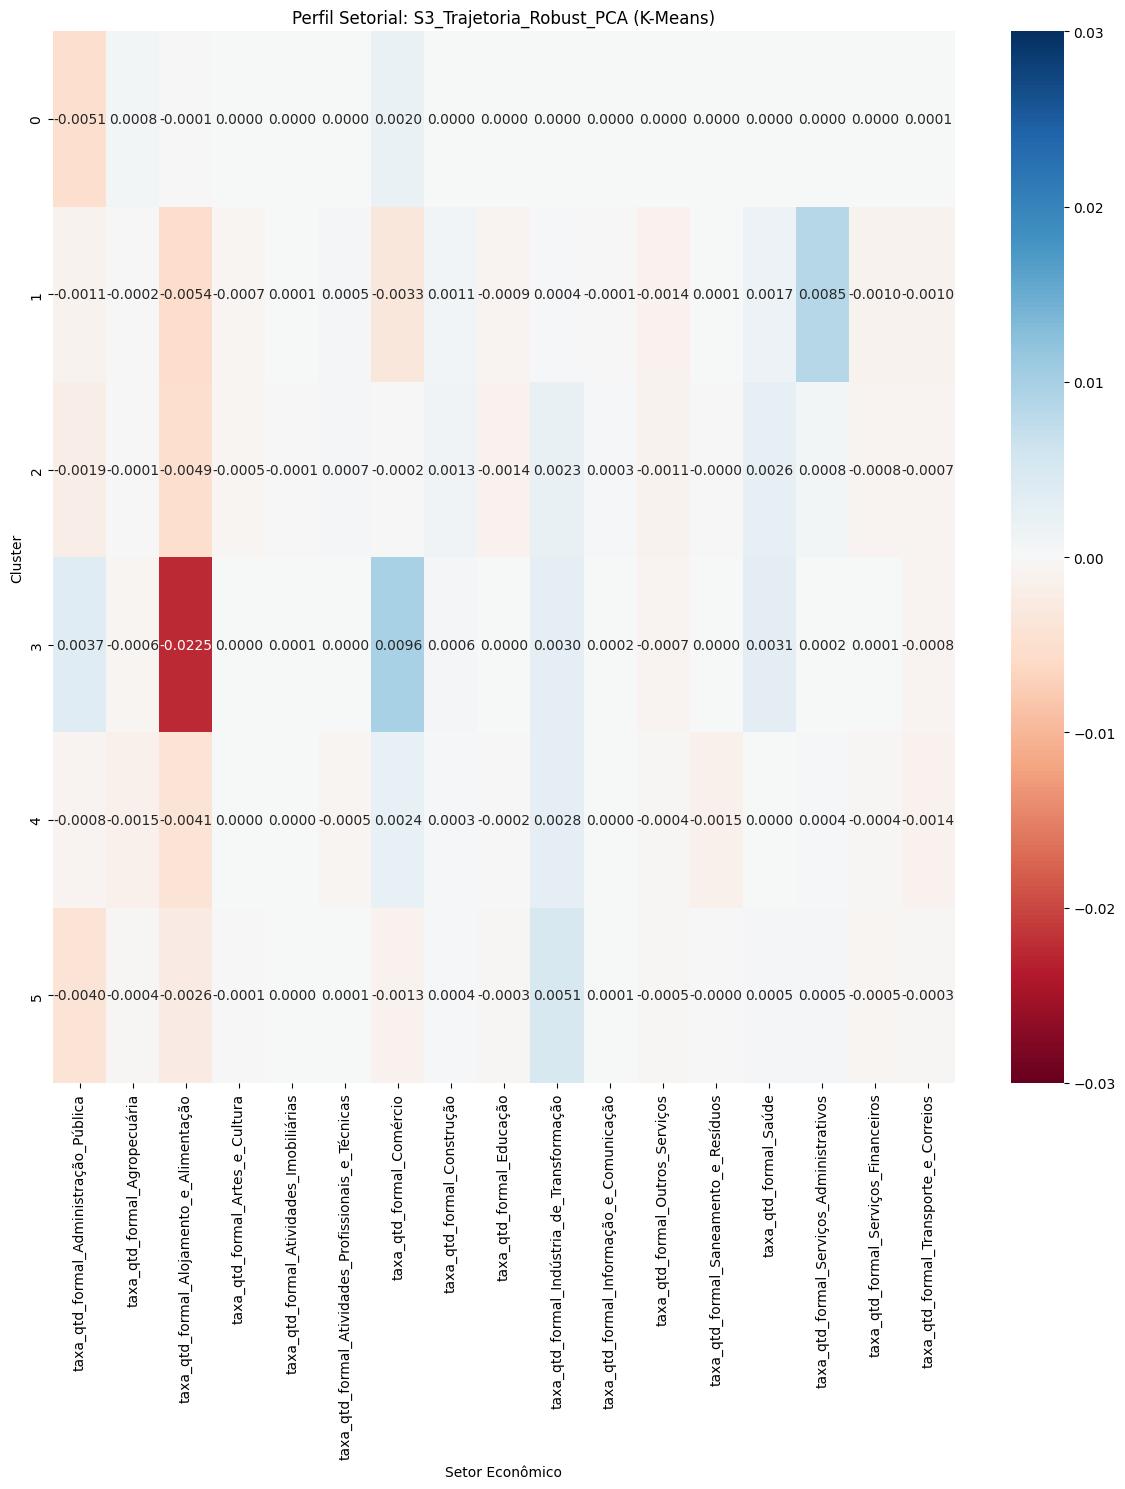


ANALISANDO: S1_Regional_Robusto_PCA | Hierarquico | K=3

>>> CLUSTER 0 (25 municípios - 3.9%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Indústria_de_Transformação: +0.00674
      + taxa_qtd_formal_Saúde: +0.00169
      + taxa_qtd_formal_Serviços_Administrativos: +0.00163
      + taxa_qtd_formal_Informação_e_Comunicação: +0.00039
      + taxa_qtd_formal_Atividades_Profissionais_e_Técnicas: +0.00011
   PONTOS DE ATENÇÃO (Onde caiu):
      - taxa_qtd_formal_Administração_Pública: -0.00099
      - taxa_qtd_formal_Comércio: -0.00111
      - taxa_qtd_formal_Educação: -0.00127
      - taxa_qtd_formal_Agropecuária: -0.00155
      - taxa_qtd_formal_Alojamento_e_Alimentação: -0.00548

>>> CLUSTER 1 (403 municípios - 62.5%)
   DESTAQUES POSITIVOS (Onde cresceu/segurou):
      + taxa_qtd_formal_Indústria_de_Transformação: +0.00111
      + taxa_qtd_formal_Comércio: +0.00069
      + taxa_qtd_formal_Atividades_Profissionais_e_Técnicas: +0.00011
      + taxa_qtd_formal_Tr

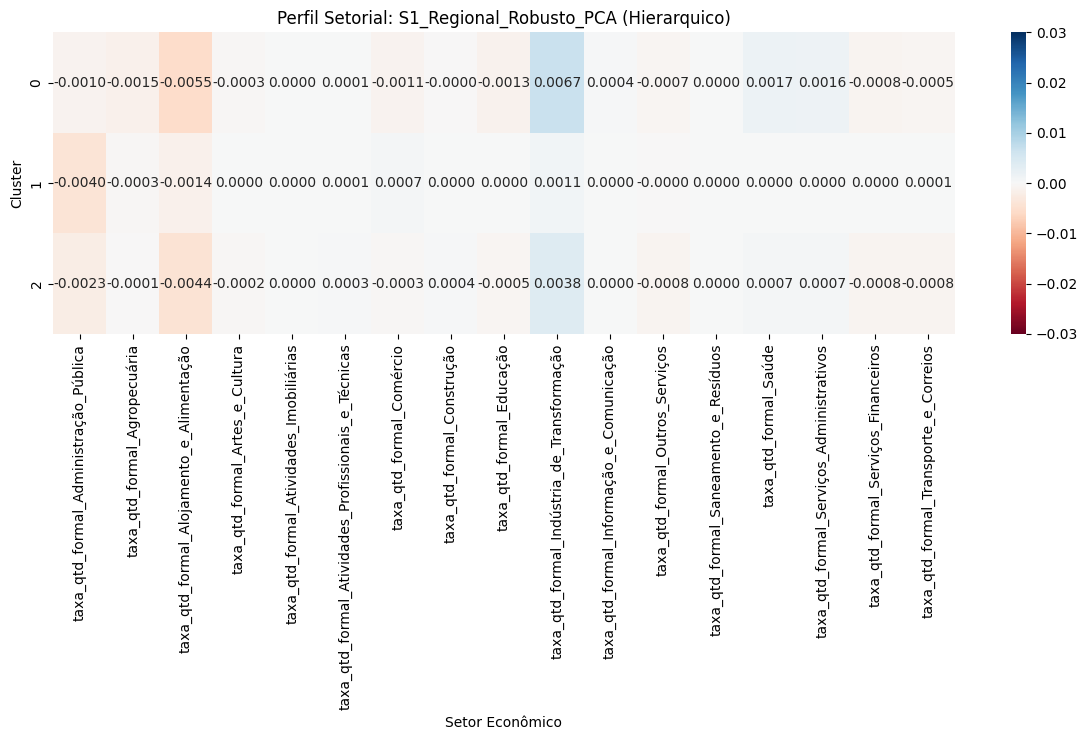

In [ ]:
inputs_finais = {k: v for k, v in inputs_experimentais.items() if '_PCA' in k}

def analisar_finalistas(nome_input, algoritmo, k, df_base, inputs_dict, dict_nomes):
    print(f"\n{'='*80}")
    print(f"ANALISANDO: {nome_input} | {algoritmo} | K={k}")
    print(f"{'='*80}")

    # Recuperar Dados
    if nome_input not in inputs_dict:
        print(f"Erro: {nome_input} não encontrado.")
        return
    X = inputs_dict[nome_input]

    # Rodar o Modelo
    if algoritmo == 'K-Means':
        model = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
        labels = model.labels_
    elif algoritmo == 'GMM':
        model = GaussianMixture(n_components=k, random_state=42).fit(X)
        labels = model.predict(X)
    elif algoritmo == 'Hierarquico':
        model = AgglomerativeClustering(n_clusters=k).fit(X)
        labels = model.labels_

    codigos_ordenados = np.sort(df_base['cod_ibge'].unique())
    mapa_cluster = dict(zip(codigos_ordenados, labels))

    # Preparar DataFrame do Perfil
    df_prof = df_base.copy()
    df_prof['Cluster'] = df_prof['cod_ibge'].map(mapa_cluster)

    # Criamos a coluna de nomes mapeando o código IBGE
    df_prof['nome_municipio'] = df_prof['cod_ibge'].map(mapa_nomes)
    df_prof['nome_municipio'] = df_prof['nome_municipio'].fillna(df_prof['cod_ibge'].astype(str))

    # Calcular Perfil Setorial (Mediana do Choque Original)
    perfil_setorial = df_prof.pivot_table(
        index='coluna', columns='Cluster', values='Choque_Original', aggfunc='median'
    )

    unique, counts = np.unique(labels, return_counts=True)

    for grp in unique:
        n_cidades = counts[grp]
        perc = (n_cidades / len(labels)) * 100
        print(f"\n>>> CLUSTER {grp} ({n_cidades} municípios - {perc:.1f}%)")


        # Análise de Setores (Top 3 Positivos e Negativos)
        setores_grp = perfil_setorial[grp].sort_values(ascending=False)

        print("   DESTAQUES POSITIVOS (Onde cresceu/segurou):")
        for setor, val in setores_grp.head(5).items():
            print(f"      + {setor}: {val:+.5f}")

        print("   PONTOS DE ATENÇÃO (Onde caiu):")
        for setor, val in setores_grp.tail(5).items():
            print(f"      - {setor}: {val:+.5f}")

    # HEATMAP
    plt.figure(figsize=(12, k*2.5))
    sns.heatmap(perfil_setorial.T, cmap='RdBu', center=0, annot=True, fmt=".4f", vmin=-0.03, vmax=0.03)
    plt.title(f"Perfil Setorial: {nome_input} ({algoritmo})")
    plt.xlabel("Setor Econômico")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()

# 1. O ""MELHOR" (S2 Estadual | GMM | K=3)
analisar_finalistas('S2_Estadual_Robusto_PCA', 'K-Means', 3, df_analise_final, inputs_finais, mapa_nomes)

# 2. Bom desnalanceamento (S3 Trajetória | K-Means | K = 3)
analisar_finalistas('S3_Trajetoria_Robust_PCA', 'K-Means', 3, df_analise_final, inputs_finais, mapa_nomes)

# 3. Bom desnalanceamento (S3 Trajetória | K-Means | K=4) - Para comparação
analisar_finalistas('S3_Trajetoria_Robust_PCA', 'K-Means', 4, df_analise_final, inputs_finais, mapa_nomes)

# 4. Bom desnalanceamento (S3 Trajetória | K-Means | K=6) - Para comparação
analisar_finalistas('S3_Trajetoria_Robust_PCA', 'K-Means', 6, df_analise_final, inputs_finais, mapa_nomes)

# 4. Melhor S1 (S1 Regional | K-Means | K=3) - Para comparação
analisar_finalistas('S1_Regional_Robusto_PCA','Hierarquico', 3, df_analise_final, inputs_finais, mapa_nomes)

Aviso: 'S1_Regional_Robust_PCA' não achado. Usando 'S1_Regional_Robusto_PCA'.


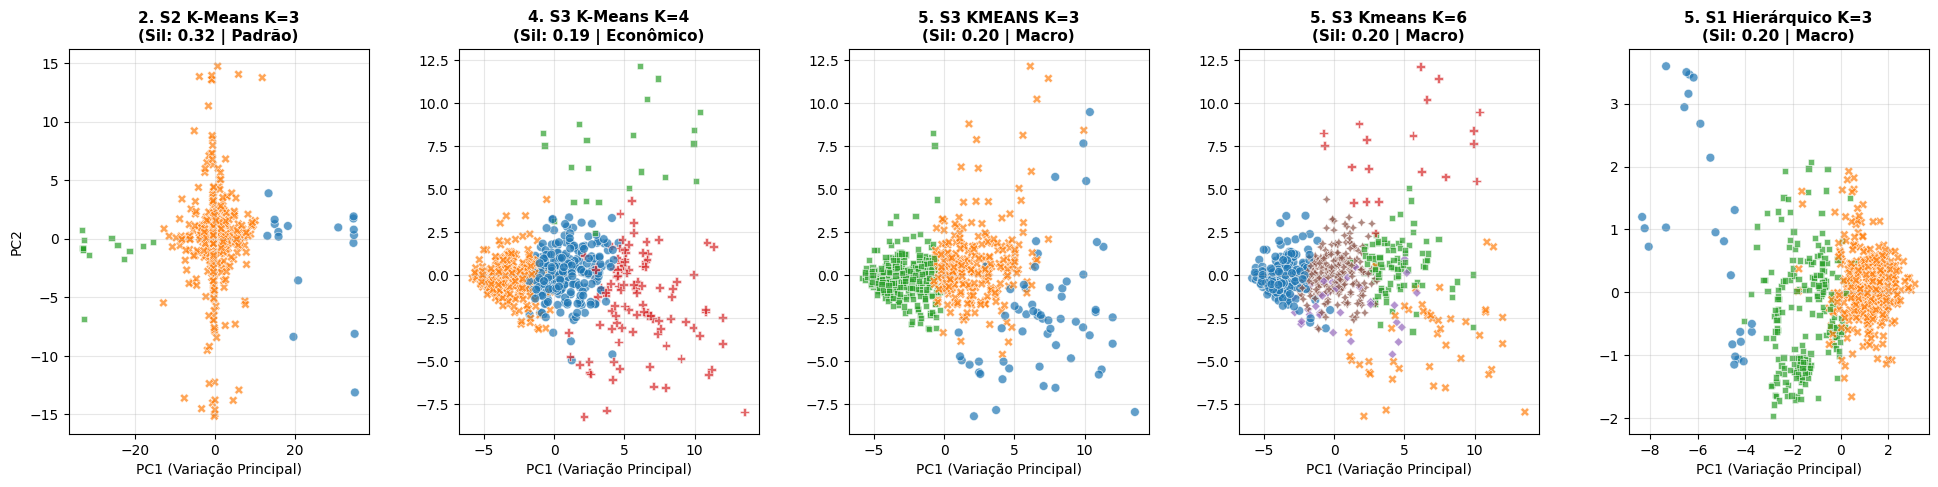

In [ ]:
# Escolhemos estes para comparar:
finalistas = [
    # (Nome do Input, Algoritmo, K, Título Descritivo)
    ('S2_Estadual_Robusto_PCA', 'K-Means', 3, '2. S2 K-Means K=3\n(Sil: 0.32 | Padrão)'),
    ('S3_Trajetoria_Robust_PCA', 'K-Means', 4, '4. S3 K-Means K=4\n(Sil: 0.19 | Econômico)'),
    ('S3_Trajetoria_Robust_PCA', 'K-Means', 3, '5. S3 KMEANS K=3\n(Sil: 0.20 | Macro)'),
    ('S3_Trajetoria_Robust_PCA', 'K-Means', 6, '5. S3 Kmeans K=6\n(Sil: 0.20 | Macro)'),
    ('S1_Regional_Robust_PCA', 'Hierarquico', 3, '5. S1 Hierárquico K=3\n(Sil: 0.20 | Macro)')

]

# Configurar a figura (1 linha, 5 colunas)
fig, axes = plt.subplots(1, 5, figsize=(24, 5))
plt.subplots_adjust(wspace=0.3)


# LOOP DE PLOTAGEM
for i, (input_key, algo, k, titulo) in enumerate(finalistas):
    ax = axes[i]
    if input_key not in inputs_experimentais:
        alternativas = [key for key in inputs_experimentais.keys() if input_key.split('_')[0] in key and 'PCA' in key]
        if alternativas:
            print(f"Aviso: '{input_key}' não achado. Usando '{alternativas[-1]}'.")
            input_key = alternativas[-1]
        else:
            ax.text(0.5, 0.5, f"Input não encontrado:\n{input_key}", ha='center', va='center')
            continue

    X = inputs_experimentais[input_key]

    # Rodar o Modelo
    if algo == 'K-Means':
        model = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
        labels = model.labels_
    elif algo == 'GMM':
        model = GaussianMixture(n_components=k, random_state=42).fit(X)
        labels = model.predict(X)
    elif algo == 'Hierarquico':
        model = AgglomerativeClustering(n_clusters=k).fit(X)
        labels = model.labels_

    # Plotar (Usando PC1 e PC2)
    # Se houver muitos pontos, usamos alpha para ver densidade
    sns.scatterplot(
        x=X[:, 0], y=X[:, 1],
        hue=labels, palette='tab10', style=labels,
        s=40, alpha=0.7, ax=ax, legend=False
    )

    ax.set_title(titulo, fontsize=11, fontweight='bold')
    ax.set_xlabel("PC1 (Variação Principal)")
    ax.set_ylabel("PC2" if i==0 else "") # Só no primeiro para limpar
    ax.grid(True, alpha=0.3)

plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

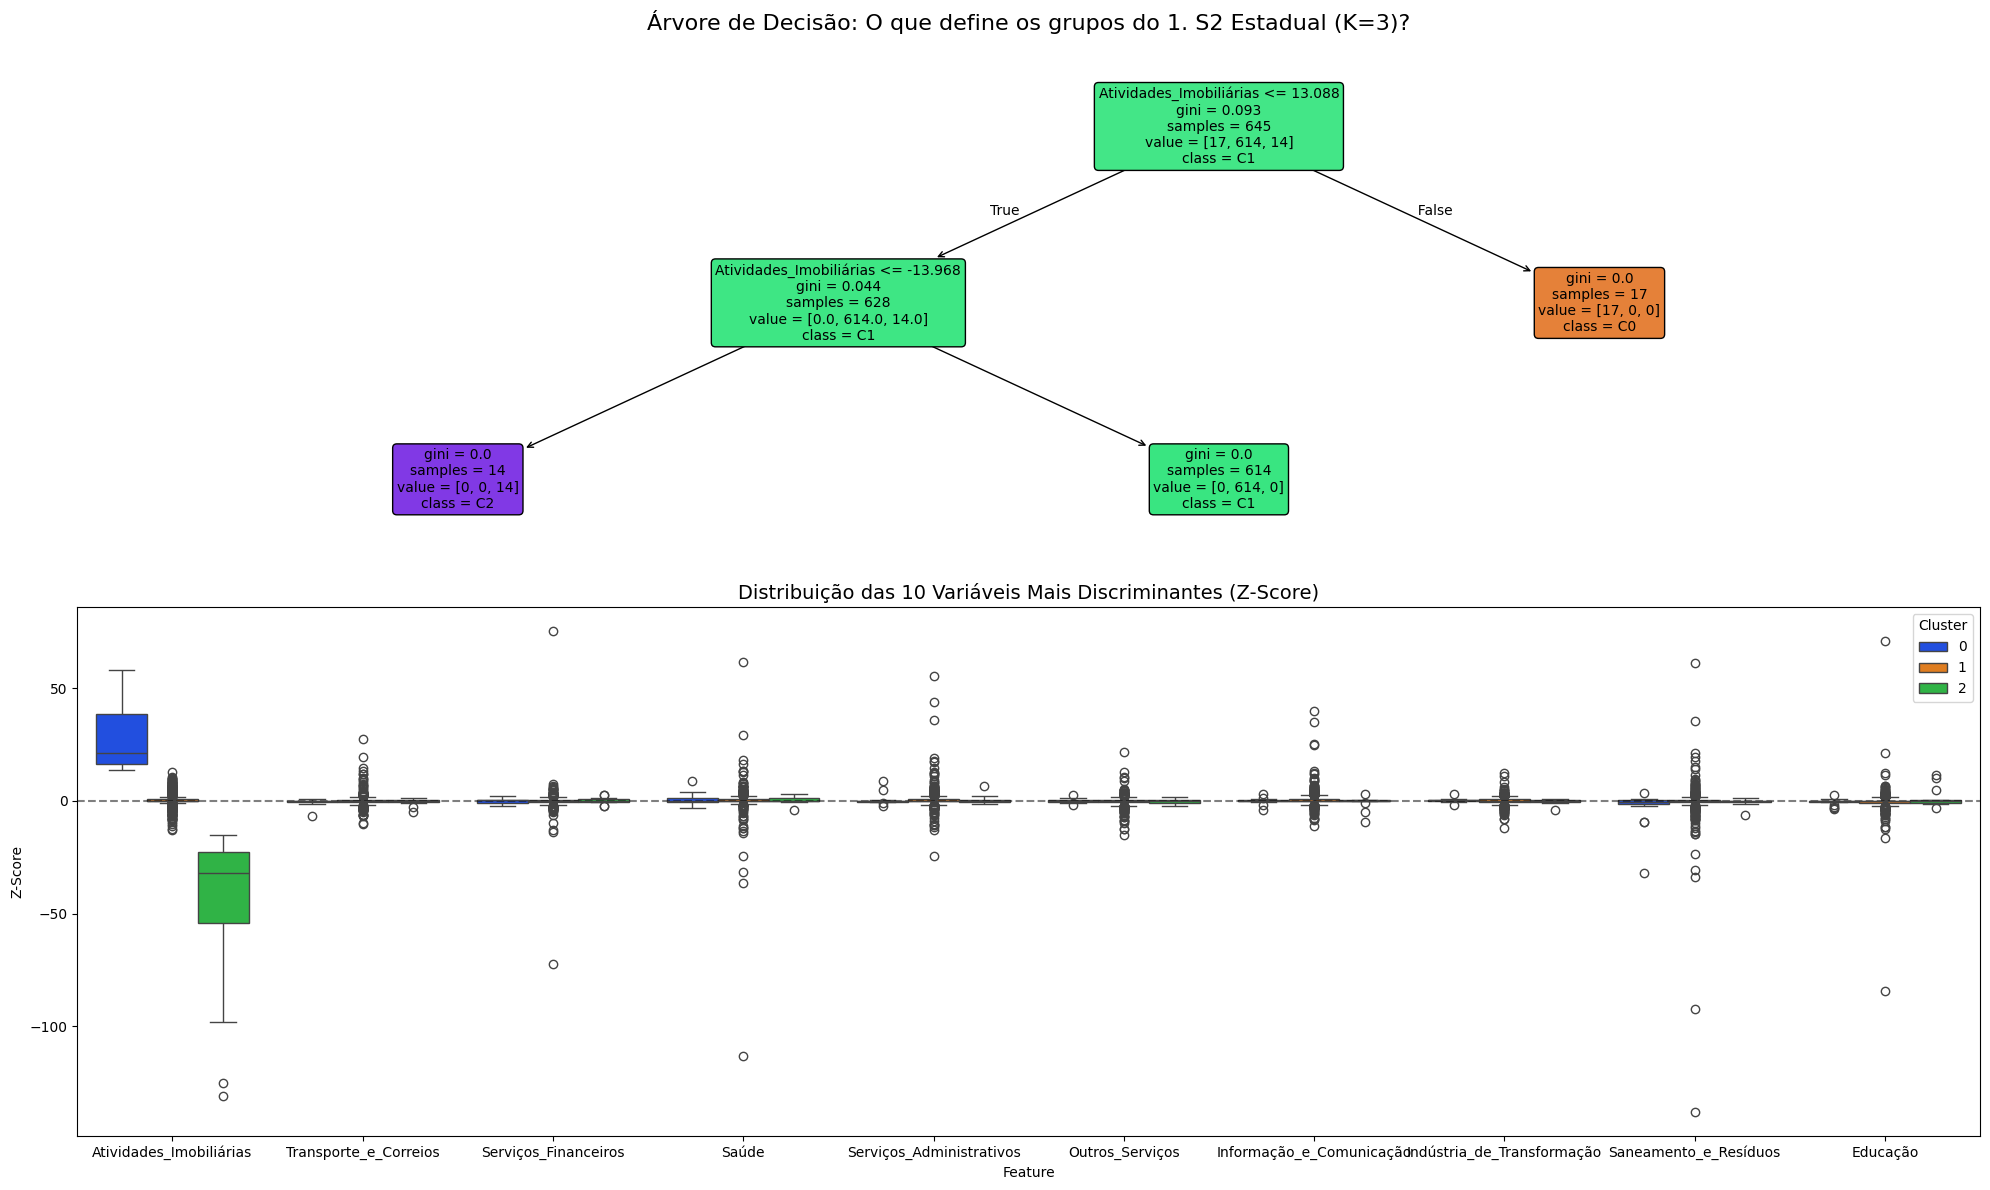

--------------------------------------------------


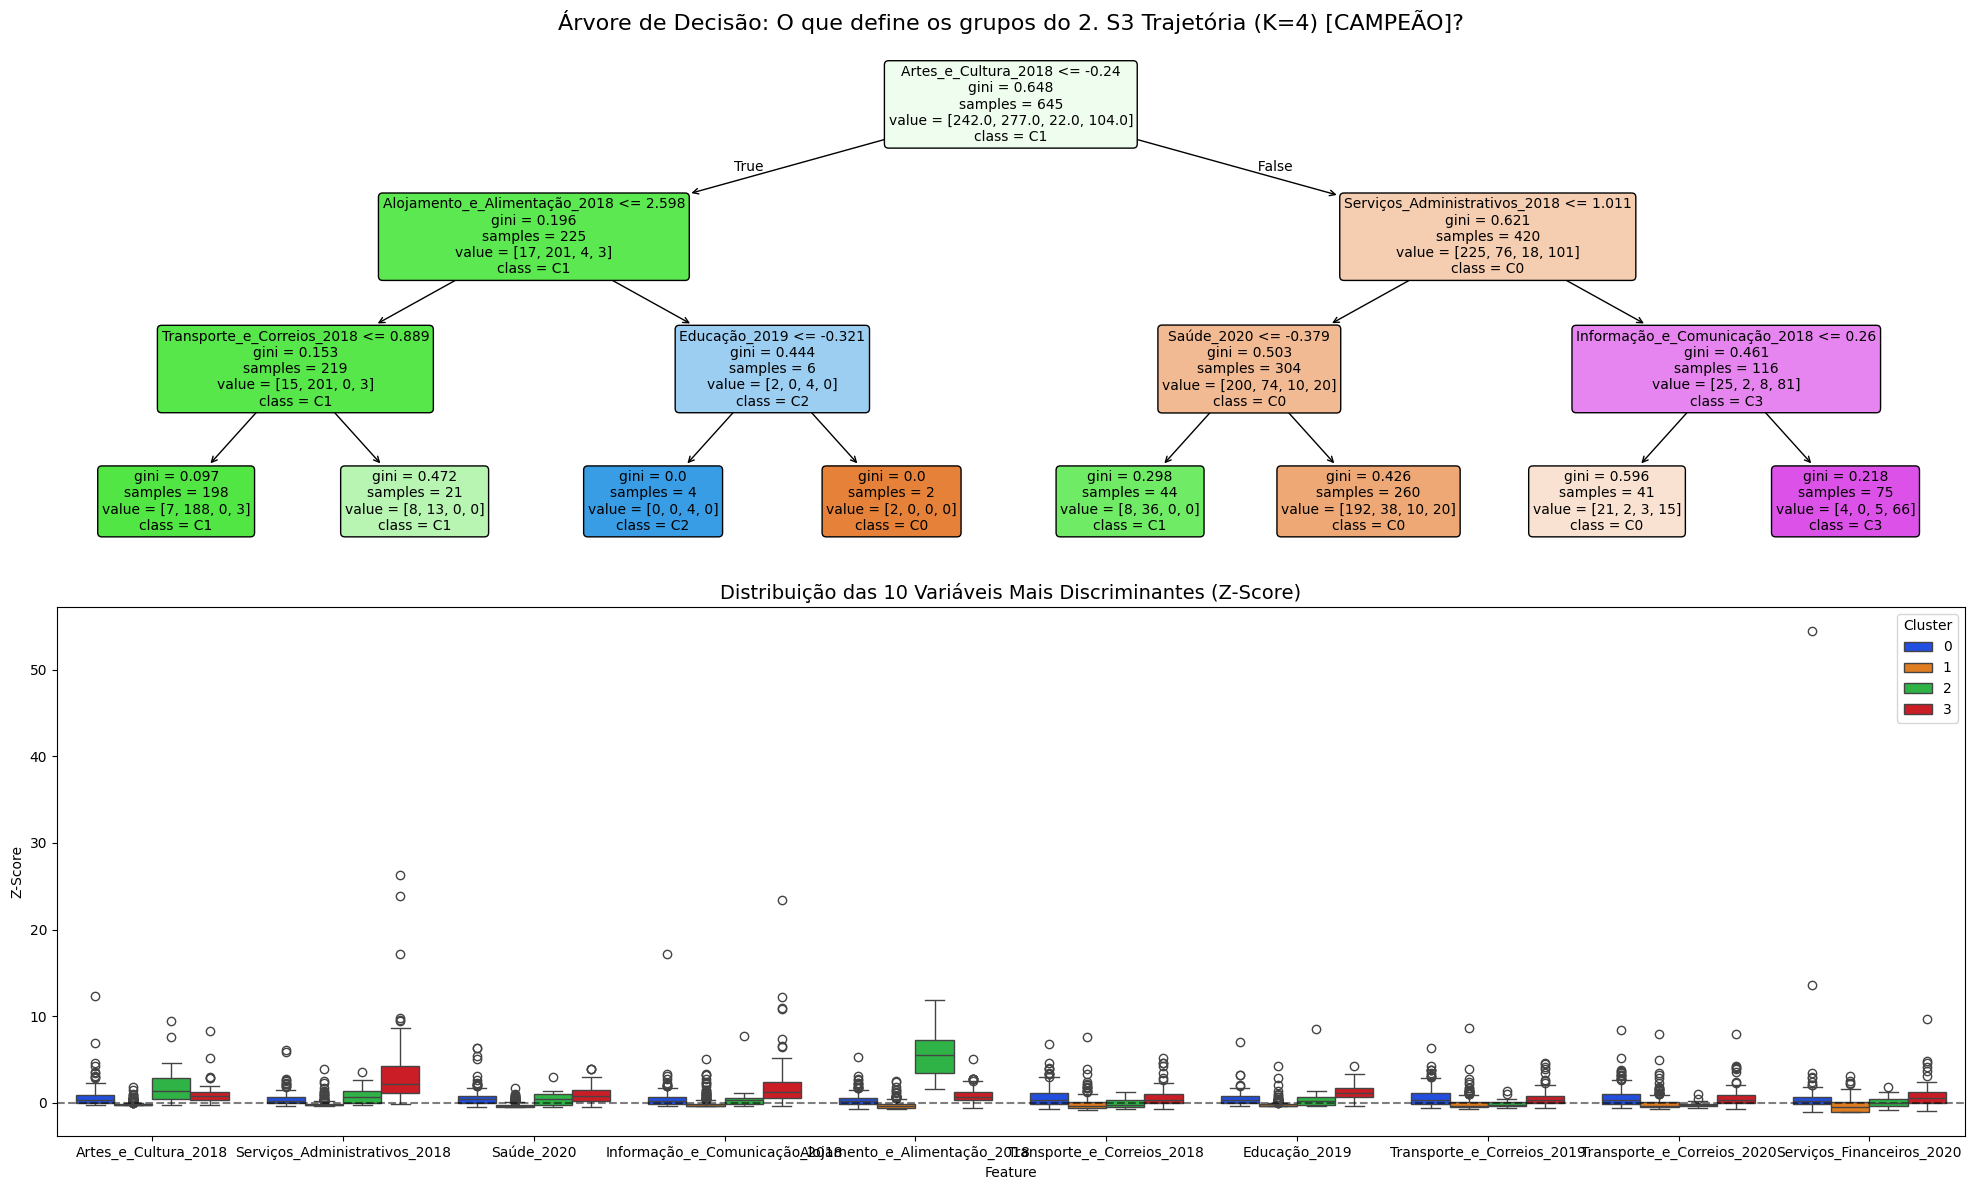

--------------------------------------------------


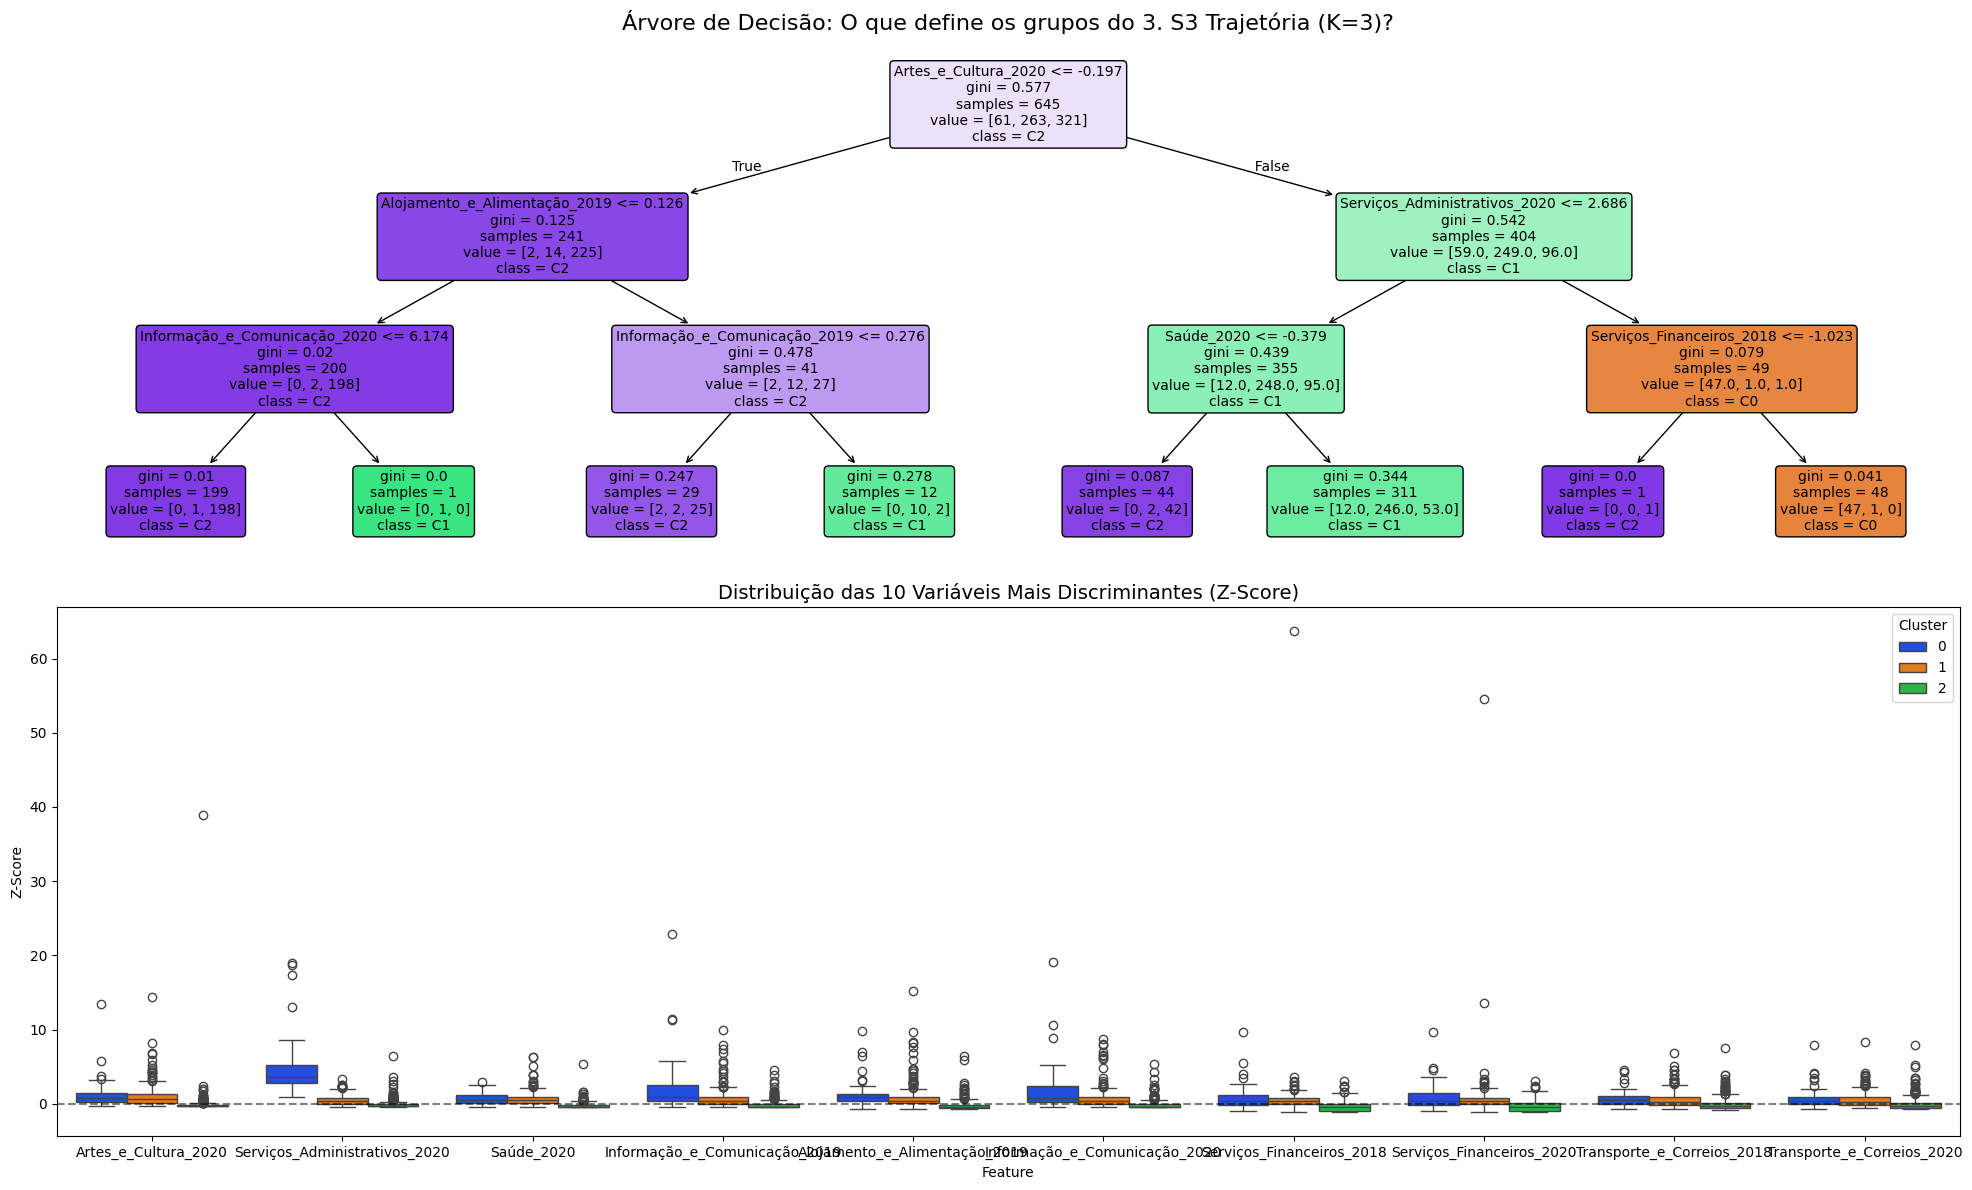

--------------------------------------------------


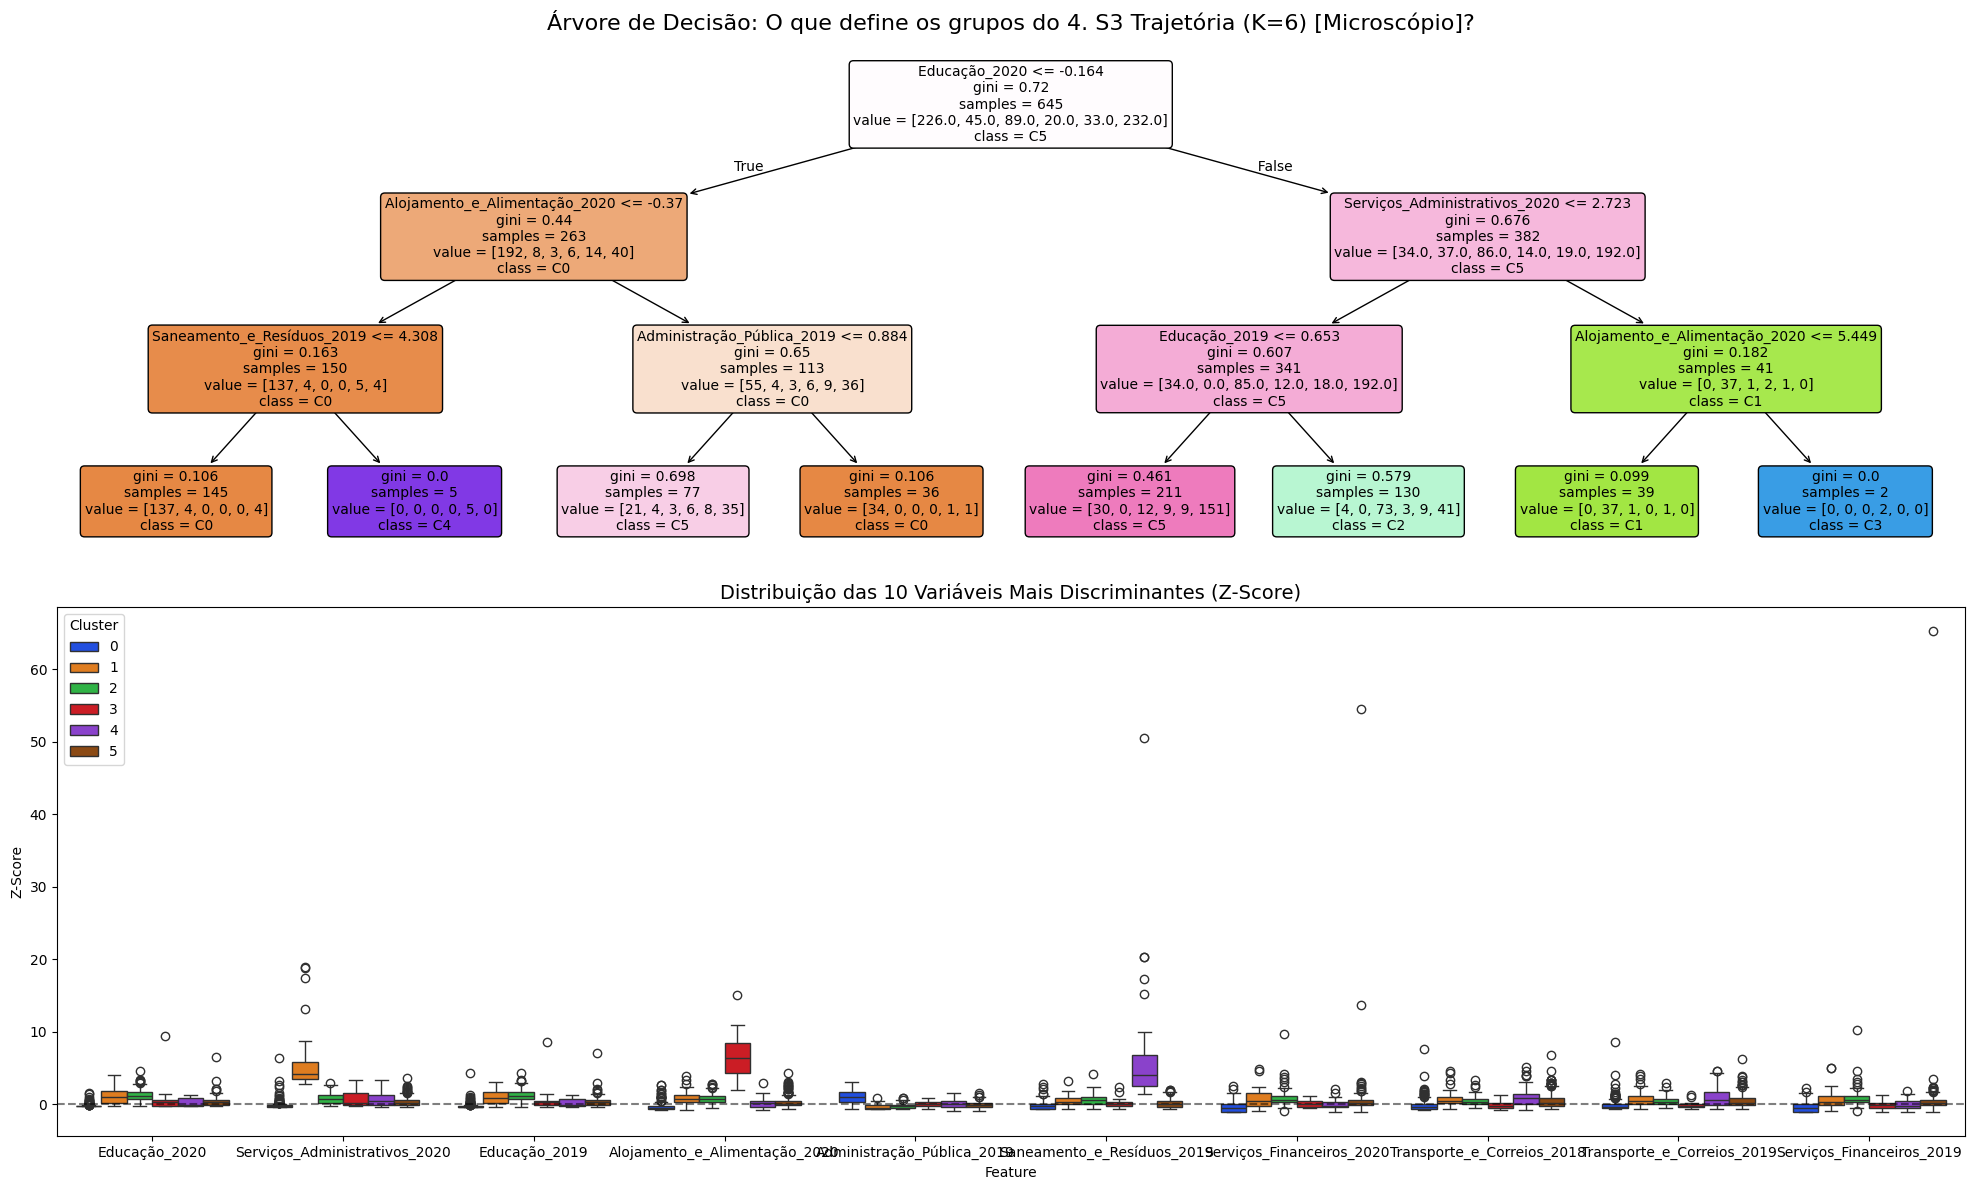

--------------------------------------------------


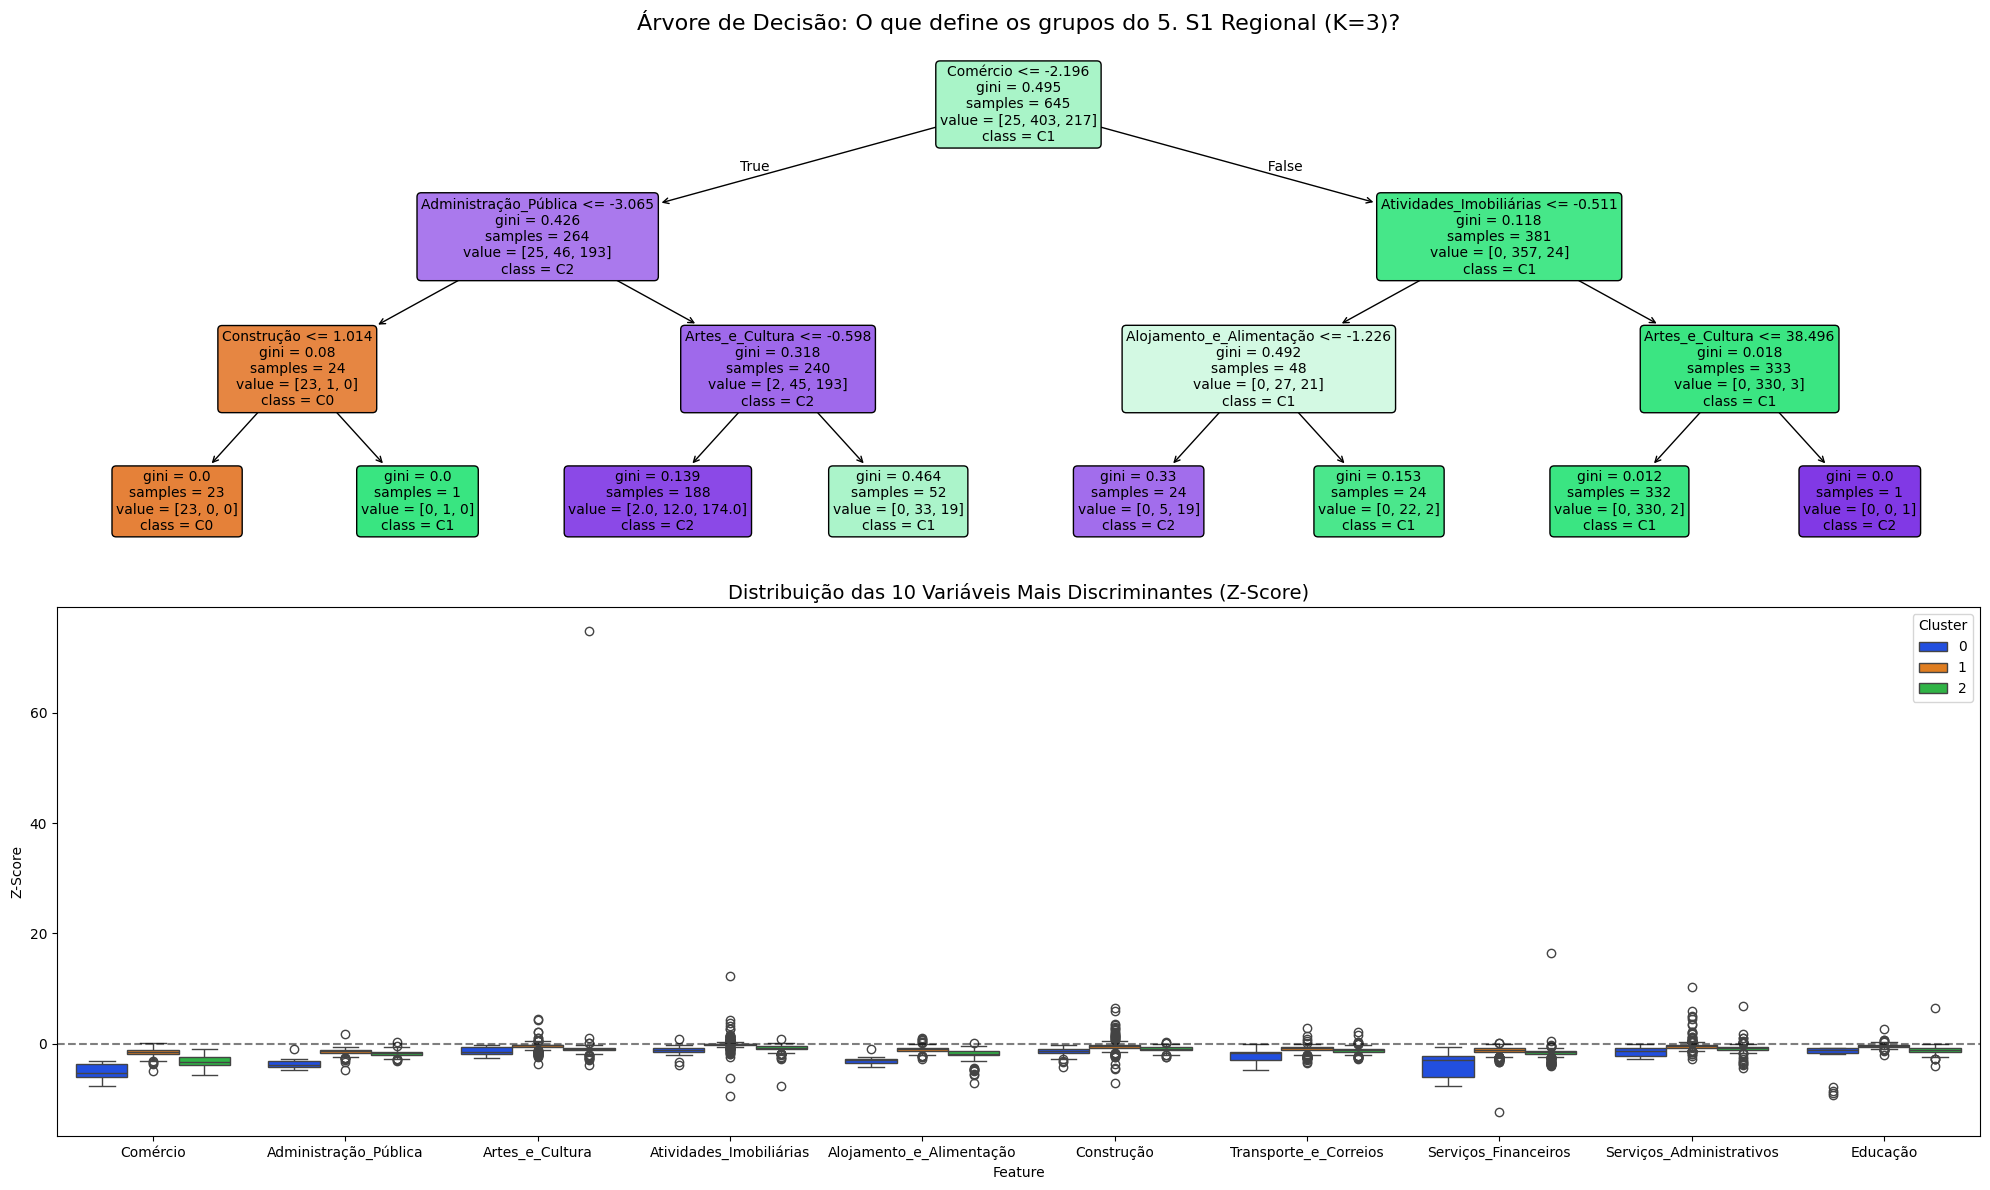

--------------------------------------------------


In [ ]:
# (Chave do Input, Algoritmo, K, Nome Amigável)
modelos_alvo = [
    ('S2_Estadual_Robusto_PCA', 'K-Means', 3, '1. S2 Estadual (K=3)'),
    ('S3_Trajetoria_Robust_PCA', 'K-Means', 4, '2. S3 Trajetória (K=4) [CAMPEÃO]'),
    ('S3_Trajetoria_Robust_PCA', 'K-Means', 3, '3. S3 Trajetória (K=3)'),
    ('S3_Trajetoria_Robust_PCA', 'K-Means', 6, '4. S3 Trajetória (K=6) [Microscópio]'),
    ('S1_Regional_Robusto_PCA', 'Hierarquico', 3, '5. S1 Regional (K=3)')
]

def get_feature_names(input_key, n_cols_esperado):
    raw_key = input_key.replace('_PCA', '')

    # Se for S3, recriamos os nomes Setor_Ano
    if 'S3' in input_key:
        # Recupera lista de setores do df_regioes limpo
        cols_taxas = [c.replace('taxa_qtd_formal_', '') for c in df_regioes.columns if 'taxa_qtd_formal' in c]
        cols_taxas = [c for c in cols_taxas if 'Internacionais' not in c and 'Domésticos' not in c]

        # Recria a lista
        nomes = []
        # A ordem do pivot geralmente é alfabética das colunas
        cols_taxas_sorted = sorted(cols_taxas)
        for c in cols_taxas_sorted:
            for ano in [2018, 2019, 2020]:
                nomes.append(f"{c}_{ano}")
        return nomes

    # Se for S2 ou S1 (apenas 2020 ou média)
    else:
        cols_taxas = [c.replace('taxa_qtd_formal_', '') for c in df_regioes.columns if 'taxa_qtd_formal' in c]
        return sorted(cols_taxas)[:n_cols_esperado]


for chave, algo, k, titulo in modelos_alvo:



    X_pca = inputs_experimentais[chave] # Dados PCA para clusterizar

    # Precisamos dos DADOS ORIGINAIS (Brutos/Normalizados) para plotar o boxplot e a árvore
    # Se usarmos o PCA na árvore, as regras serão "PC1 > 0.5", o que é difícil de ler.
    chave_bruta = chave.replace('_PCA', '')
    if chave_bruta in inputs_experimentais:
        X_interpret = inputs_experimentais[chave_bruta]

    # Recuperar nomes das features
    feature_names = get_feature_names(chave, X_interpret.shape[1])
    if len(feature_names) != X_interpret.shape[1]:
        # Fallback se os nomes não baterem
        feature_names = [f"Var_{i}" for i in range(X_interpret.shape[1])]

    # Gerar Clusters
    if algo == 'K-Means':
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X_pca)
    elif algo == 'Hierarquico':
        model = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = model.fit_predict(X_pca)
    elif algo == 'GMM': # Caso tenha GMM na lista
        from sklearn.mixture import GaussianMixture
        model = GaussianMixture(n_components=k, random_state=42)
        labels = model.predict(X_pca)

    # 3Treinar Árvore de Decisão "Explicadora"
    tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42) # Profundidade 3 para ser legível
    tree_clf.fit(X_interpret, labels)

    # 4Pegar as Features Mais Importantes (Top 6)
    importances = tree_clf.feature_importances_
    indices_top = np.argsort(importances)[::-1][:10]
    top_features = [feature_names[i] for i in indices_top]

    # PLOT
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3) # Grid: Árvore em cima, Boxplots embaixo

    # Árvore de Decisão
    ax_tree = fig.add_subplot(gs[0, :])
    plot_tree(tree_clf, feature_names=feature_names, class_names=[f"C{i}" for i in range(k)],
              filled=True, rounded=True, fontsize=10, ax=ax_tree)
    ax_tree.set_title(f"Árvore de Decisão: O que define os grupos do {titulo}?", fontsize=16)

    # B. Boxplots das Top 5 Variáveis mais importantes
    # Criar DF temporário para plotar
    df_plot = pd.DataFrame(X_interpret[:, indices_top[:10]], columns=top_features[:10])
    df_plot['Cluster'] = labels

    # Derreter para o Seaborn
    df_melt = df_plot.melt(id_vars='Cluster', var_name='Feature', value_name='Z-Score')

    ax_box = fig.add_subplot(gs[1, :])
    sns.boxplot(data=df_melt, x='Feature', y='Z-Score', hue='Cluster', palette='bright', ax=ax_box)
    ax_box.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax_box.set_title("Distribuição das 10 Variáveis Mais Discriminantes (Z-Score)", fontsize=14)

    plt.tight_layout()
    plt.show()
    print("-" * 50)

In [ ]:
df_regioes.columns

Index(['dfano', 'cod_ibge', 'emprego_formal', 'emp_c_sal',
       'massa_rendimentos_num', 'qtd_formal_Administração_Pública',
       'qtd_formal_Agropecuária', 'qtd_formal_Alojamento_e_Alimentação',
       'qtd_formal_Artes_e_Cultura', 'qtd_formal_Atividades_Imobiliárias',
       'qtd_formal_Atividades_Profissionais_e_Técnicas', 'qtd_formal_Comércio',
       'qtd_formal_Construção', 'qtd_formal_Educação',
       'qtd_formal_Indústria_de_Transformação',
       'qtd_formal_Informação_e_Comunicação', 'qtd_formal_Outros_Serviços',
       'qtd_formal_Saneamento_e_Resíduos', 'qtd_formal_Saúde',
       'qtd_formal_Serviços_Administrativos',
       'qtd_formal_Serviços_Financeiros', 'qtd_formal_Transporte_e_Correios',
       'ipca_alimentos_bebidas', 'ipca_artigos_residencia', 'ipca_comunicacao',
       'ipca_despesas_pessoais', 'ipca_educacao', 'ipca_habitacao',
       'ipca_saude_cuidados_pessoais', 'ipca_transportes', 'ipca_vestuario',
       'ipca_geral', 'localidade', 'pib_agropecuaria',

Variáveis Externas Encontradas: 19
['pib_agropecuaria', 'pib_impostos_liq_sub', 'pib_industria', 'pib', 'pib_servicos', 'pib_servicos_adm_publica', 'pib_valor_add', 'Pop_65_mais', 'Pop_2020', 'pib_ind_pc', 'razao_pib_renda', 'per_capita_pib_agropecuaria', 'per_capita_pib_industria', 'per_capita_pib_servicos', 'per_capita_pib_servicos_adm_publica', 'per_capita_pib_impostos_liq_sub', 'per_capita_pib', 'per_capita_pib_valor_add', 'perc_Pop_65_mais']

--- TOP Variáveis Externas que Explicam os Clusters ---


,Variavel,Importancia
2,pib_industria,0.55369
10,razao_pib_renda,0.44631
0,pib_agropecuaria,0.00000
1,pib_impostos_liq_sub,0.00000
3,pib,0.00000
5,pib_servicos_adm_publica,0.00000
4,pib_servicos,0.00000
6,pib_valor_add,0.00000
7,Pop_65_mais,0.00000
8,Pop_2020,0.00000


/tmp/ipython-input-3811668018.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df_analise, palette='Set2')
/tmp/ipython-input-3811668018.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df_analise, palette='Set2')
/tmp/ipython-input-3811668018.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df_analise, palette='Set2')
/tmp/ipython-input-3811668018.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.

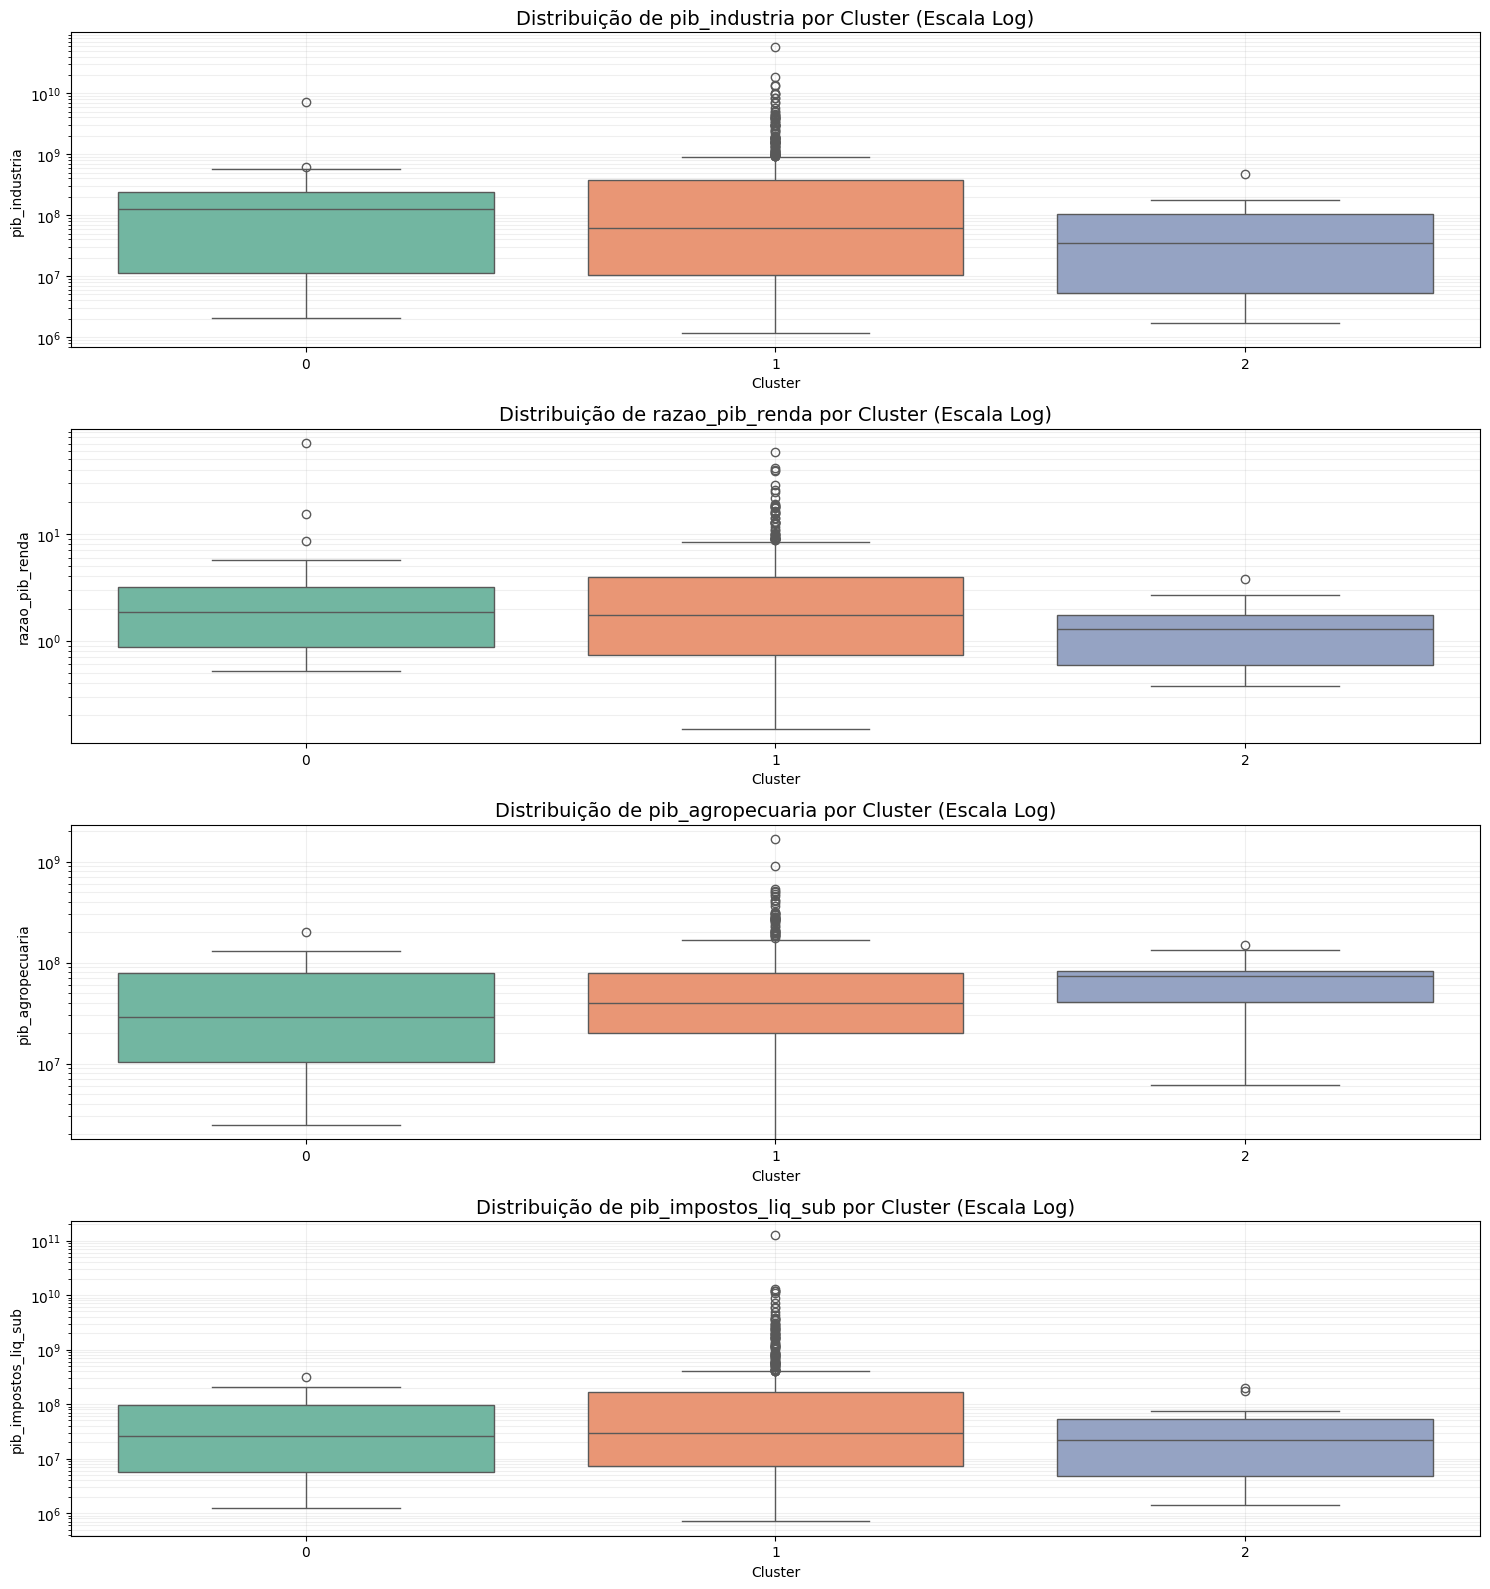

In [ ]:


# --- 1. RECUPERAR OS CLUSTERS (S2 K=3) ---
chave_modelo = 'S2_Estadual_Robusto_PCA'
k = 3

if chave_modelo in inputs_experimentais:
    X_input = inputs_experimentais[chave_modelo]
else:
    # Fallback de segurança
    keys = [x for x in inputs_experimentais.keys() if 'S2' in x and 'PCA' in x]
    X_input = inputs_experimentais[keys[0]]

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_input)
labels = kmeans.labels_

# Preparar DataFrame (Ano 2020)
df_analise = df_regioes[df_regioes['dfano'] == 2020].copy()
if len(labels) == len(df_analise):
    df_analise['Cluster'] = labels
else:
    df_analise['Cluster'] = labels[-len(df_analise):]

# --- 2. SELECIONAR VARIÁVEIS EXTERNAS (PIB, POPULAÇÃO, ETC.) ---
# Vamos excluir as taxas formais e pegar o resto que for numérico
cols_proibidas = ['Cluster', 'dfano', 'cod_municipio', 'cod_ibge']
cols_taxas = [c for c in df_analise.columns if 'taxa_qtd_formal' in c]

# Seleção automática de colunas interessantes (PIB, VAB, População)
# Adicione ou remova termos desta lista conforme o nome real das suas colunas
termos_interesse = ['pib', 'pop', 'vab', 'renda', 'arrecadacao', 'valor_adicionado']

cols_externas = [
    c for c in df_analise.columns
    if c not in cols_proibidas
    and c not in cols_taxas
    and pd.api.types.is_numeric_dtype(df_analise[c])
    and any(termo in c.lower() for termo in termos_interesse)
]

print(f"Variáveis Externas Encontradas: {len(cols_externas)}")
print(cols_externas)

# Vamos usar uma Árvore para ver qual variável externa melhor "adivinha" o cluster
if cols_externas:
    X_ext = df_analise[cols_externas].fillna(0)
    y_clus = df_analise['Cluster']

    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_ext, y_clus)

    importancias = pd.DataFrame({
        'Variavel': cols_externas,
        'Importancia': clf.feature_importances_
    }).sort_values('Importancia', ascending=False)

    print("\n--- TOP Variáveis Externas que Explicam os Clusters ---")
    display(importancias.head(10))

    # Pegamos as Top 4 variáveis externas para plotar
    top_cols_plot = importancias.head(4)['Variavel'].tolist()

    plt.figure(figsize=(15, 4 * len(top_cols_plot)))

    for i, col in enumerate(top_cols_plot):
        plt.subplot(len(top_cols_plot), 1, i+1)

        # Usamos escala logarítmica para PIB/População pois a diferença costuma ser exponencial
        sns.boxplot(x='Cluster', y=col, data=df_analise, palette='Set2')
        plt.yscale('log')
        plt.title(f'Distribuição de {col} por Cluster (Escala Log)', fontsize=14)
        plt.grid(True, which="both", ls="-", alpha=0.2)

    plt.tight_layout()
    plt.show()

else:
    print("Nenhuma variável externa (PIB, Pop, etc.) foi encontrada com os nomes padrão.")
    print("Verifique os nomes das colunas em df_regioes.columns")

/tmp/ipython-input-1590794136.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df_analise, palette='Set1', showfliers=False)
/tmp/ipython-input-1590794136.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df_analise, palette='Set1', showfliers=False)


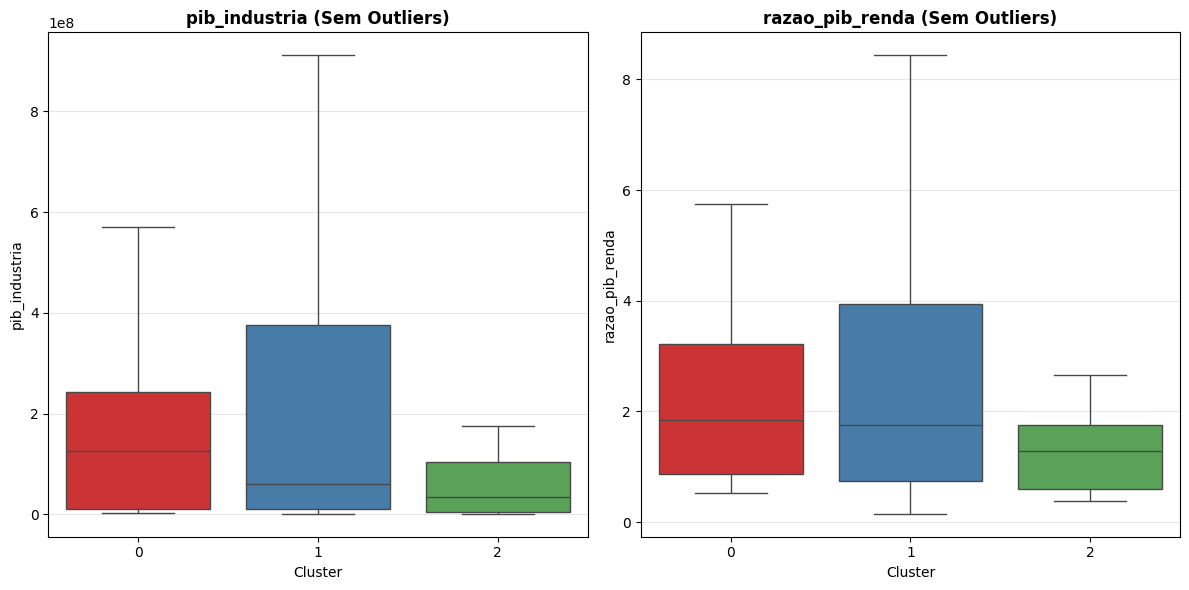


--- A Diferença Real (Medianas) ---
         pib_industria  razao_pib_renda
Cluster                                
0          126227777.0         1.848696
1           60718597.0         1.757261
2           35363827.0         1.283576


In [ ]:
# Variáveis que a árvore disse serem importantes
vars_importantes = ['pib_industria', 'razao_pib_renda']

plt.figure(figsize=(12, 6))

for i, col in enumerate(vars_importantes):
    plt.subplot(1, 2, i+1)

    # TRUQUE 1: showfliers=False
    # Isso esconde os pontinhos extremos (São Paulo, etc) e foca na caixa (mediana)
    sns.boxplot(x='Cluster', y=col, data=df_analise, palette='Set1', showfliers=False)

    # Títulos e ajustes
    plt.title(f'{col} (Sem Outliers)', fontsize=12, fontweight='bold')
    plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# --- A PROVA DOS NÚMEROS (Tabela de Medianas) ---
print("\n--- A Diferença Real (Medianas) ---")
# Usamos mediana porque a média é poluída pelos outliers
print(df_analise.groupby('Cluster')[vars_importantes].median())

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering


In [ ]:
# CONFIGURAÇÃO
modelos = [
    ('S2_Estadual_Robusto_PCA', 'K-Means', 3, 'S2 (Estrutura) K=3'),
    ('S3_Trajetoria_Robust_PCA', 'K-Means', 3, 'S3 (Trajetória) K=3'),
    ('S3_Trajetoria_Robust_PCA', 'K-Means', 4, 'S3 (Trajetória) K=4'),
    ('S3_Trajetoria_Robust_PCA', 'K-Means', 6, 'S3 (Trajetória) K=6'),
    ('S1_Regional_Robusto_PCA', 'Hierarquico', 3, 'S1 (Regional) K=3')
]

# Vamos olhar para o comportamento médio desses setores em 2020 (resultado final)
setores_chave = [
    col for col in df_regioes.columns
    if col.startswith('taxa_qtd_formal_')
]

fig, axes = plt.subplots(len(modelos), 1, figsize=(12, 4 * len(modelos)))
plt.subplots_adjust(hspace=0.6)

if len(modelos) == 1: axes = [axes] # Garantir iterabilidade

for i, (chave, algo, k, titulo) in enumerate(modelos):
    ax = axes[i]

    # 1. Gerar Labels
    if chave not in inputs_experimentais:
        # Tenta corrigir nome
        keys = [x for x in inputs_experimentais.keys() if chave[:5] in x]
        if keys: chave = keys[0]
        else: continue

    X = inputs_experimentais[chave]

    if algo == 'K-Means':
        labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    elif algo == 'Hierarquico':
        labels = AgglomerativeClustering(n_clusters=k).fit_predict(X)

    # Montar Perfil (Z-Score Médio dos Setores Chave em 2020)

    df_plot = df_regioes[df_regioes['dfano'] == 2020].copy()
    df_plot['Cluster'] = labels[:len(df_plot)] # Segurança de tamanho

    # Selecionar colunas de interesse
    cols_plot = setores_chave

    # Calcular Z-Score apenas para visualização (para as cores ficarem comparáveis)
    # Z = (Média do Cluster - Média do Estado) / Desvio do Estado
    perfil_cluster = df_plot.groupby('Cluster')[cols_plot].mean()
    media_estado = df_plot[cols_plot].mean()
    std_estado = df_plot[cols_plot].std()

    perfil_z = (perfil_cluster - media_estado) / std_estado
    print(perfil_z)
    # Limpar nomes

    # 3. Plotar Heatmap
    sns.heatmap(
        perfil_z,
        ax=ax,
        cmap='RdBu_r',
        center=0,
        annot=True,
        fmt='.1f',
        vmin=-1.5, vmax=1.5, # Trava a escala para não estourar com outliers
        cbar=i == 0 # Só mostra a barra de cores no primeiro
    )
    ax.set_title(f"MODELO {titulo}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Cluster ID")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
nome_input_pca = "S3_Trajetoria_Robust_PCA"

nome_input_bruto = nome_input_pca.replace('_PCA', '')
if nome_input_bruto in inputs_experimentais:
    X_bruto = inputs_experimentais[nome_input_bruto]

In [ ]:
# --- YOUR CONFIGURATIONS ---
config_k4 = {
    0: {'nome': 'Indústria',                   'cor': '#984ea3'}, # Roxo
    1: {'nome': 'Agro Dependente',             'cor': '#4daf4a'}, # Verde
    2: {'nome': 'Turismo',                     'cor': '#e41a1c'}, # Vermelho
    3: {'nome': 'Centro de Serviços Urbanos',  'cor': '#377eb8'}  # Azul
}

config_k6 = {
    0: {'nome': 'Agro Dependente',             'cor': '#4daf4a'}, # Verde
    1: {'nome': 'Hubs Admnistrativos',           'cor': '#377eb8'}, # Azul
    2: {'nome': 'Polos Saúde/Comércio/Educa',  'cor': '#00c5cd'}, # Ciano
    3: {'nome': 'Turismo',                     'cor': '#e41a1c'}, # Vermelho
    4: {'nome': 'Gestão/Infra Ambiental',      'cor': '#ff7f00'}, # Laranja
    5: {'nome': 'Indústria?',              'cor': '#984ea3'}  # Roxo
}

# --- PLOTTING FUNCTION ---
def plotar_k_custom(k_n, config_dict, X_pca_data, X_bruto_data, colunas_s3_data):

    # Gerar Clusters
    kmeans = KMeans(n_clusters=k_n, random_state=42, n_init=10).fit(X_pca_data)
    labels = kmeans.labels_

    # Criar DF Longo (Igual ao anterior)
    # Use X_bruto_data and colunas_s3_data passed as arguments
    df_plot = pd.DataFrame(X_bruto_data, columns=colunas_s3_data)
    df_plot['Cluster_ID'] = labels  # Mantemos o ID numérico primeiro

    # Check if 'Ano' column exists and is numeric, if not, create it
    # Also, ensure 'Setor' column is correctly extracted
    df_long = df_plot.melt(id_vars='Cluster_ID', var_name='Setor_Ano', value_name='Z_Score')

    # The format of 'Setor_Ano' from get_feature_names for S3 is 'setor_ano'
    # We need to split by the last underscore to get 'setor' and 'ano'
    df_long['Setor'] = df_long['Setor_Ano'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    df_long['Ano'] = df_long['Setor_Ano'].apply(lambda x: x.split('_')[-1]).astype(int)

    # Clean up Setor names
    df_long['Setor'] = df_long['Setor'].str.replace('taxa_qtd_formal_', '').str.replace('_', ' ')

    # Mapear ID -> Nome
    id_to_name = {k: v['nome'] for k, v in config_dict.items()}
    df_long['Cluster_Nome'] = df_long['Cluster_ID'].map(id_to_name)

    # Criar Paleta de Cores (Dicionário: Nome -> Hex)
    custom_palette = {v['nome']: v['cor'] for k, v in config_dict.items()}

    # Calcular Média por Cluster (Nome)
    df_agg = df_long.groupby(['Cluster_Nome', 'Setor', 'Ano'])['Z_Score'].mean().reset_index()

    # Plotar
    g = sns.FacetGrid(df_agg, col="Setor", col_wrap=4, height=3, aspect=1.4, sharey=False)

    # Adicionar linha zero
    g.map(plt.axhline, y=0, ls="--", c="gray", alpha=0.5)

    # Plotar linhas com a paleta customizada
    g.map_dataframe(sns.lineplot, x="Ano", y="Z_Score", hue="Cluster_Nome",
                    palette=custom_palette, marker='o', linewidth=3)

    # Ajustes Finais
    g.add_legend(title="Perfil Econômico")
    g.set_axis_labels("", "Z-Score")

    for ax in g.axes.flat:
        ax.set_xticks([2018, 2019, 2020])
        ax.grid(True, axis='y', alpha=0.3)

    plt.subplots_adjust(top=0.90)
    g.fig.suptitle(f"Dinâmica dos Clusters (K={k_n})", fontsize=20, fontweight='bold')
    plt.show()

# --- Prepare data for plotting ---
# Assuming 'S3_Trajetoria_Robust_PCA' is the desired PCA input for clustering
# and 'S3_Trajetoria_Robust' is the corresponding raw data for interpretation.

# Get PCA data
input_key_pca = 'S3_Trajetoria_Robust_PCA'
X_pca_for_plot = inputs_experimentais[input_key_pca]

# Get raw data (winsorized, but not PCA transformed) for interpreting clusters
input_key_bruto = 'S3_Trajetoria_Robust'
X_bruto_for_plot = inputs_experimentais[input_key_bruto]

# Get feature names for the raw data
# X_bruto_for_plot.shape[1] gives the number of columns in the raw S3 data
colunas_s3_for_plot = get_feature_names(input_key_bruto, X_bruto_for_plot.shape[1])

# --- EXECUTAR ---
plotar_k_custom(4, config_k4, X_pca_for_plot, X_bruto_for_plot, colunas_s3_for_plot)
plotar_k_custom(6, config_k6, X_pca_for_plot, X_bruto_for_plot, colunas_s3_for_plot)

In [ ]:
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import geopandas as gpd


In [ ]:
try:
    gdf_sp = gpd.read_file('/content/SP_Municipios_2024.shp')
    gdf_rgi = gpd.read_file('/content/SP_RG_Imediatas_2024.shp')

    # Converter para String
    col_cod = 'CD_MUN' if 'CD_MUN' in gdf_sp.columns else gdf_sp.columns[0]
    gdf_sp[col_cod] = gdf_sp[col_cod].astype(str)
    col_rgi = 'CD_RGIM' if 'CD_RGIM' in gdf_rgi.columns else gdf_rgi.columns[0]
    gdf_rgi[col_rgi] = gdf_rgi[col_rgi].astype(str)

    if 'df_clusters' not in globals():

        # Recria rápido usando o input S3 já processado
        nome_input = "S3_Trajetoria_Robust_PCA"

        # Tenta encontrar a chave correta no dicionário de inputs
        if nome_input not in inputs_experimentais:
             # Fallback: procura por chaves que contenham S3 e PCA
             keys = [k for k in inputs_experimentais.keys() if 'S3' in k and 'PCA' in k]
             if not keys:
                 raise ValueError("Input S3 não encontrado em inputs_experimentais.")
             nome_input = keys[-1]

        X = inputs_experimentais[nome_input]

        # Roda o KMeans novamente para garantir que temos os labels
        km4 = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X)
        km6 = KMeans(n_clusters=6, random_state=42, n_init=10).fit(X)

        # Cria o DataFrame de clusters
        df_clusters = pd.DataFrame({'cod_ibge': np.sort(df_analise_final['cod_ibge'].unique())})
        df_clusters['Cluster_K4'] = km4.labels_
        df_clusters['Cluster_K6'] = km6.labels_
        df_clusters['cod_ibge'] = df_clusters['cod_ibge'].astype(str)

    # Garante que a chave de junção (cod_ibge) é string em ambos os lados
    df_clusters['cod_ibge'] = df_clusters['cod_ibge'].astype(str)
    gdf_plot = gdf_sp.merge(df_clusters, left_on=col_cod, right_on='cod_ibge', how='left')

    # Converter para int para usar como índice de cor, mas tratar NaN antes
    gdf_plot['Cluster_K4'] = gdf_plot['Cluster_K4'].fillna(-1).astype(int)
    gdf_plot['Cluster_K6'] = gdf_plot['Cluster_K6'].fillna(-1).astype(int)


    #PLOT
    def plotar_manual_simples(ax, coluna_cluster, config_dict, titulo):

        # Se o valor do cluster estiver no dict, usa a cor. Senão, cinza.
        def get_color(val):
            if val in config_dict: return config_dict[val]['cor']
            return 'lightgrey'

        # Usamos uma coluna temporária para não alterar os dados originais
        col_cor = f'cor_{coluna_cluster}'
        gdf_plot[col_cor] = gdf_plot[coluna_cluster].map(get_color)
        gdf_rgi.boundary.plot(ax=ax, linewidth=1.5, edgecolor='black')

        # Plota o mapa usando a coluna de cores definida
        gdf_plot.plot(color=gdf_plot[col_cor], linewidth=0.05, edgecolor='white', ax=ax)

        # Cria a legenda manualmente
        patches = [mpatches.Patch(color=v['cor'], label=f"{k}: {v['nome']}") for k, v in sorted(config_dict.items())]
        ax.legend(handles=patches, loc='lower right', fontsize=10, title="Legenda")
        ax.set_title(titulo, fontsize=16, fontweight='bold')
        ax.set_axis_off()

    # 5. Gerar Figura Lado a Lado
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))

    plotar_manual_simples(axes[0], 'Cluster_K4', config_k4, "Mapa Essencial (K=4)")
    plotar_manual_simples(axes[1], 'Cluster_K6', config_k6, "Mapa Detalhado (K=6)")

    plt.tight_layout()
    plt.show()
    print(" Mapa gerado com sucesso!")

except Exception as e:
    print("Ërro ao plotar")

In [ ]:
pd.crosstab(df_clusters['Cluster_K4'], df_clusters['Cluster_K6'])


In [ ]:
pd.crosstab(df_clusters['Cluster_K4'], df_clusters['Cluster_K6'], normalize='index').round(3)


In [ ]:
# Adiciona o nome da cidade ao dataframe
df_clusters['nome_cidade'] = df_clusters['cod_ibge'].map(mapa_nomes)

# Cidades por cluster K=4
cidades_k4 = {
    cluster: df_clusters[df_clusters['Cluster_K4'] == cluster]['nome_cidade'].tolist()
    for cluster in sorted(df_clusters['Cluster_K4'].unique())
}

# Cidades por cluster K=6

cidades_k6 = {
    cluster: df_clusters[df_clusters['Cluster_K6'] == cluster]['nome_cidade'].tolist()
    for cluster in sorted(df_clusters['Cluster_K6'].unique())
}

# Exibe resultados
print("=== Cidades por cluster (K=4) ===")
for c, lista in cidades_k4.items():
    print(f"Cluster {c}: {lista}")

print("\n=== Cidades por cluster (K=6) ===")
for c, lista in cidades_k6.items():
    print(f"Cluster {c}: {lista}")
